# 0.0. Imports

In [1]:
import numpy          as np
import pandas         as pd
import psycopg2       as pg
import boruta         as bt
import seaborn        as sns
import pandas.io.sql  as psql
import scikitplot     as skplt
import os
import optuna
import pickle
import warnings

from IPython.core.display  import HTML
from tabulate              import tabulate
from matplotlib            import pyplot    as plt
from scipy                 import stats     as ss

from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

from imblearn.combine      import SMOTETomek
from IPython.core.display import Image


import xgboost                                      as xgb
from pandas_profiling        import ProfileReport
from sklearn                 import preprocessing   as pp
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn                 import metrics         as m
from boruta                  import BorutaPy
from lightgbm                import LGBMClassifier
from skopt                   import forest_minimize
from skopt.plots             import plot_convergence
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm
from sklearn                 import base
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import precision_score, recall_score, accuracy_score, balanced_accuracy_score


In [2]:
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1. Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict



def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 20000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(accuracy_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']



def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Load dataset

In [5]:
# Credenciais do Banco de dados Postgress
param_dict={
    'USER': os.getenv('USER_CDS'),
    'HOST': os.getenv('HOST_CDS'),
    'PORT': os.getenv('PORT_NUM'),
    'DATABASE': os.getenv('DATABASE_CDS'),
    'PWD': os.getenv('PWD_CDS')
}

# Acessando os dados com SQL

conn = pg.connect(user=param_dict['USER'],
                  password= param_dict['PWD'],
                  host=param_dict['HOST'],
                  port=param_dict['PORT'],
                  database=param_dict['DATABASE'])

#SELECT nspname
#FROM pg_catalog.pg_namespace pn 

#select tablename
#from pg_catalog.pg_tables
#where schemaname = 'pa004

query ='''
SELECT *
FROM pa004.users u inner join pa004.vehicle v on (u.id=v.id)
                   inner join pa004.insurance i on (u.id = i.id)
'''
df_raw=psql.read_sql(query, conn)
#df_raw= df_raw.drop(df_raw.columns[[5,9]], axis=1)
conn.close()



# 1.0. Data Description

In [6]:
df_aux= df_raw.copy
df1 = df_raw.copy()

df1= df1.drop(df1.columns[[5]], axis=1)
df1['id']=df_raw.iloc[:,0]


## 1.1. Rename Columns

In [7]:
df1 = df1[['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']]



## 1.2 Split Data into Training/validation and Test data set

In [8]:
split_data = np.random.rand(len(df1)) < 0.80
train_data = df1[split_data]
future_test = df1[~split_data]

df1=train_data.copy()

## 1.3 Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 305222
Number of Cols: 12


## 1.4 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.5 Check Data

### 1.5.1 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.5.2 Check Balanced Data

In [12]:
df1['response'].value_counts(normalize=True)

0    0.878249
1    0.121751
Name: response, dtype: float64

## 1.6 Data Descriptive

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.6.1 Numerical Attributes

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190603.480539,190681.5,109974.012722,-0.000318,-1.199492
1,age,20.0,85.0,65.0,38.831129,36.0,15.518988,0.672456,-0.566172
2,driving_license,0.0,1.0,1.0,0.997854,1.0,0.046275,-21.517307,460.997508
3,region_code,0.0,52.0,52.0,26.400292,28.0,13.234296,-0.115158,-0.869677
4,previously_insured,0.0,1.0,1.0,0.458545,0.0,0.498279,0.166394,-1.972326
5,annual_premium,2630.0,540165.0,537535.0,30540.572983,31650.0,17246.157520,1.839708,35.519234
6,policy_sales_channel,1.0,163.0,162.0,112.047592,133.0,54.194540,-0.901161,-0.968448
7,vintage,10.0,299.0,289.0,154.523612,154.0,83.655782,-0.000625,-1.199957
8,response,0.0,1.0,1.0,0.121751,0.0,0.326998,2.313479,3.352207


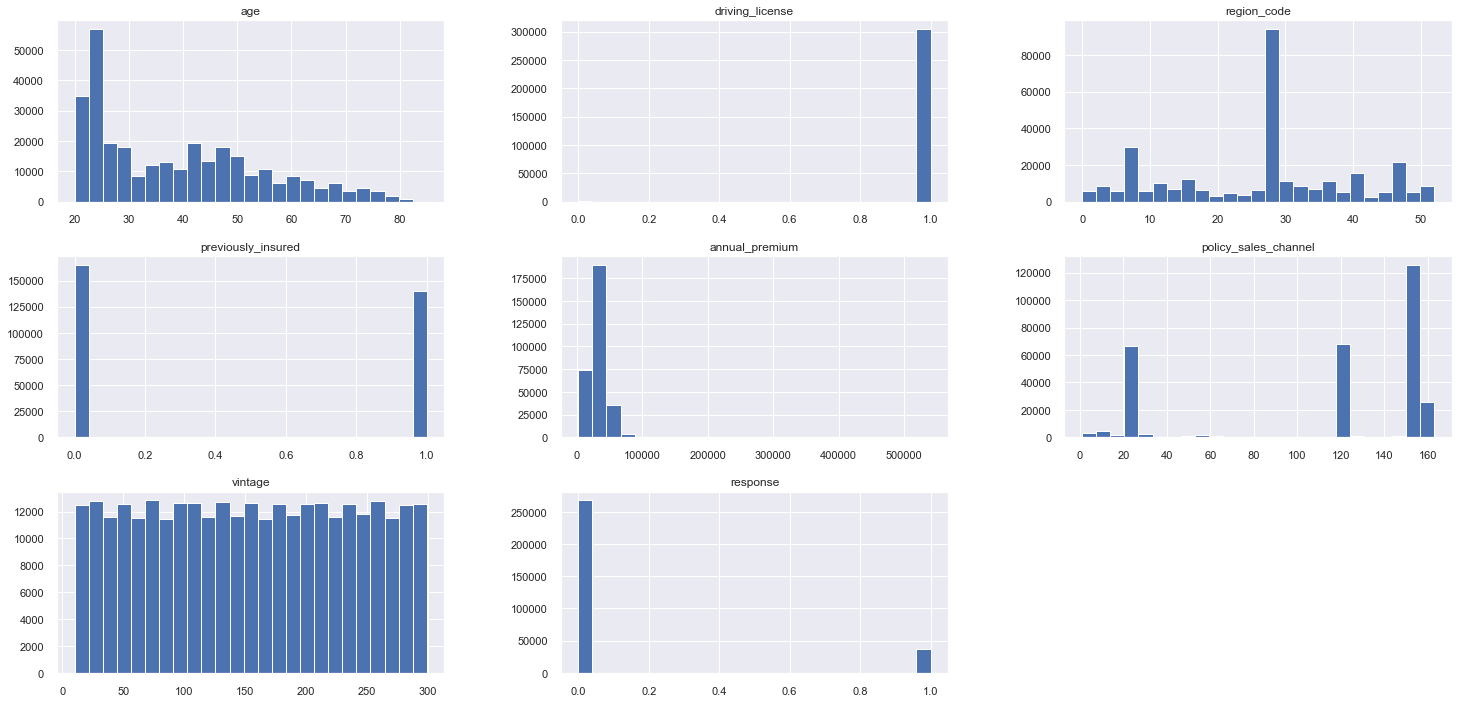

In [15]:
num_attributes.drop(columns = ['id'], inplace = True)
num_attributes.hist(bins=25);

### 1.6.2 Categorical Attributes

In [16]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,305222,305222,305222
unique,2,3,2
top,Male,1-2 Year,Yes
freq,165021,160577,154151


# 2.0. Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

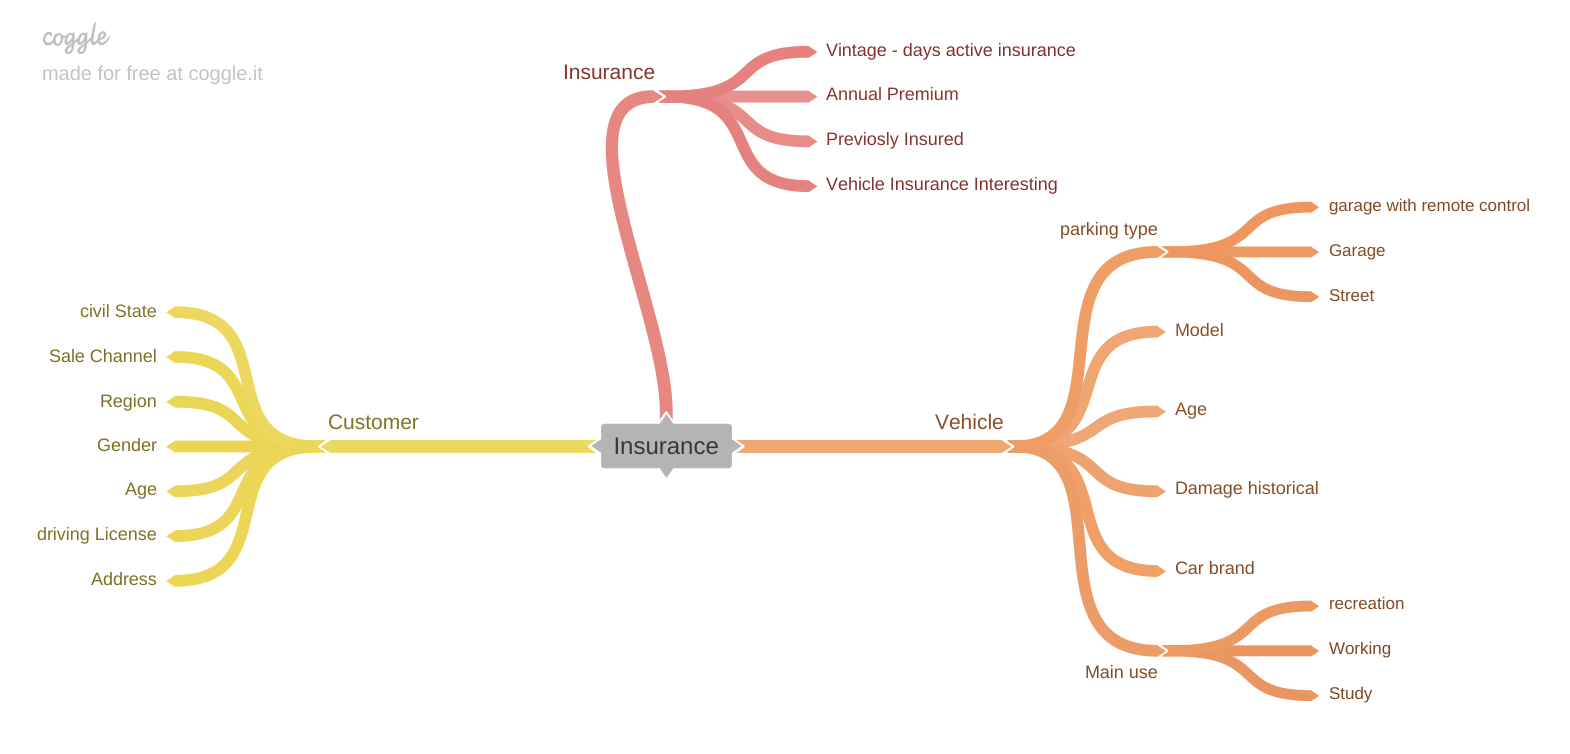

In [150]:
Image('/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/images/MindMap.png')

## 2.1.2 Hypothesis

 **H1 -** Mulheres tem mais interesse em comprar seguro de veículos que homens.
 
 **H2 -** Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.
 
 **H3 -** Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.
 
 **H4 -** Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.
 
 **H5 -** Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos. 
 
 **H6 -** Clientes que pagaram entre 30000 e 40000 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.
 
 **H7 -** Homens tem mais eventos de dano a veículos, do que mulheres. 

## 2.1.3 Feature Engineering

In [19]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

In [20]:
df3=df2.copy()

# 4.0. Exploratory Data Analysis

In [21]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

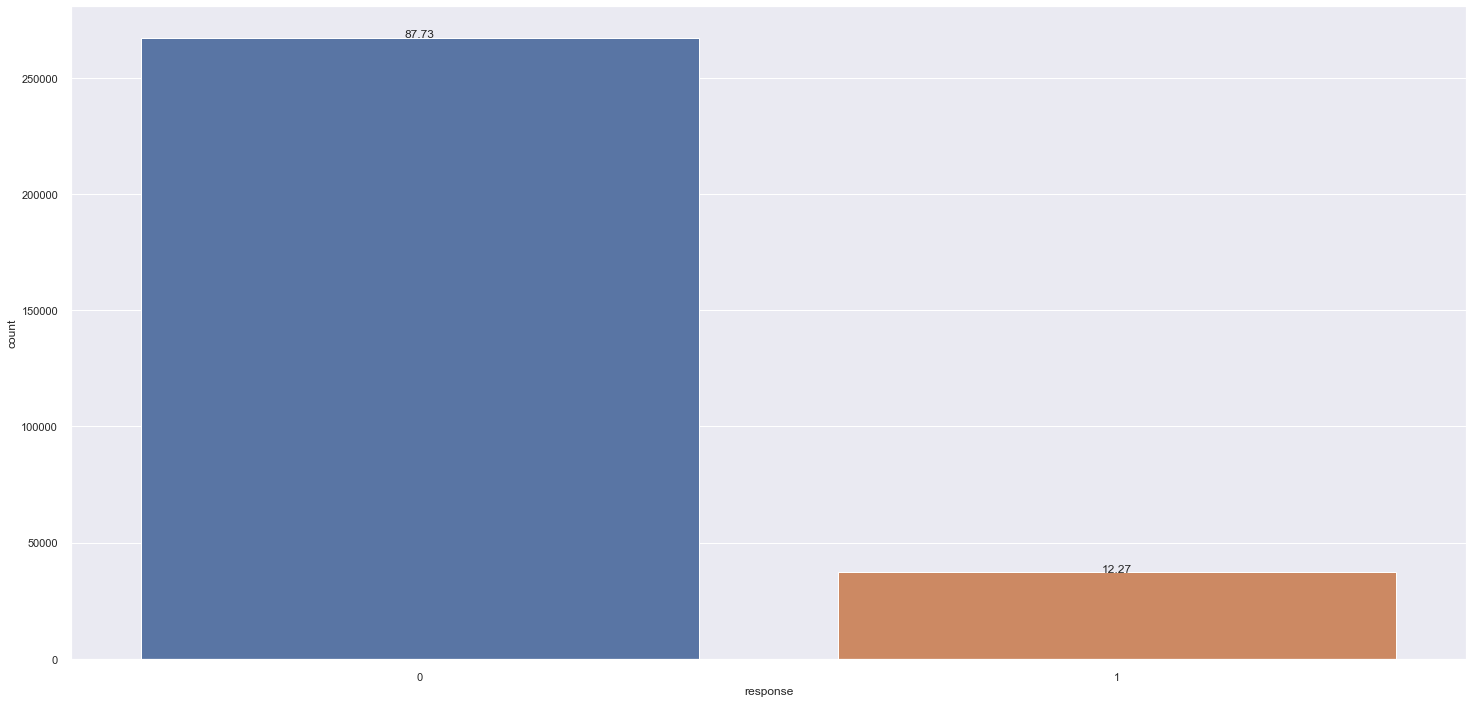

In [66]:
ax=sns.countplot(df4['response'])
total=len(df4['response'])
graphic_percentage(ax,total)

### 4.1.2. Age

<AxesSubplot:xlabel='response', ylabel='age'>

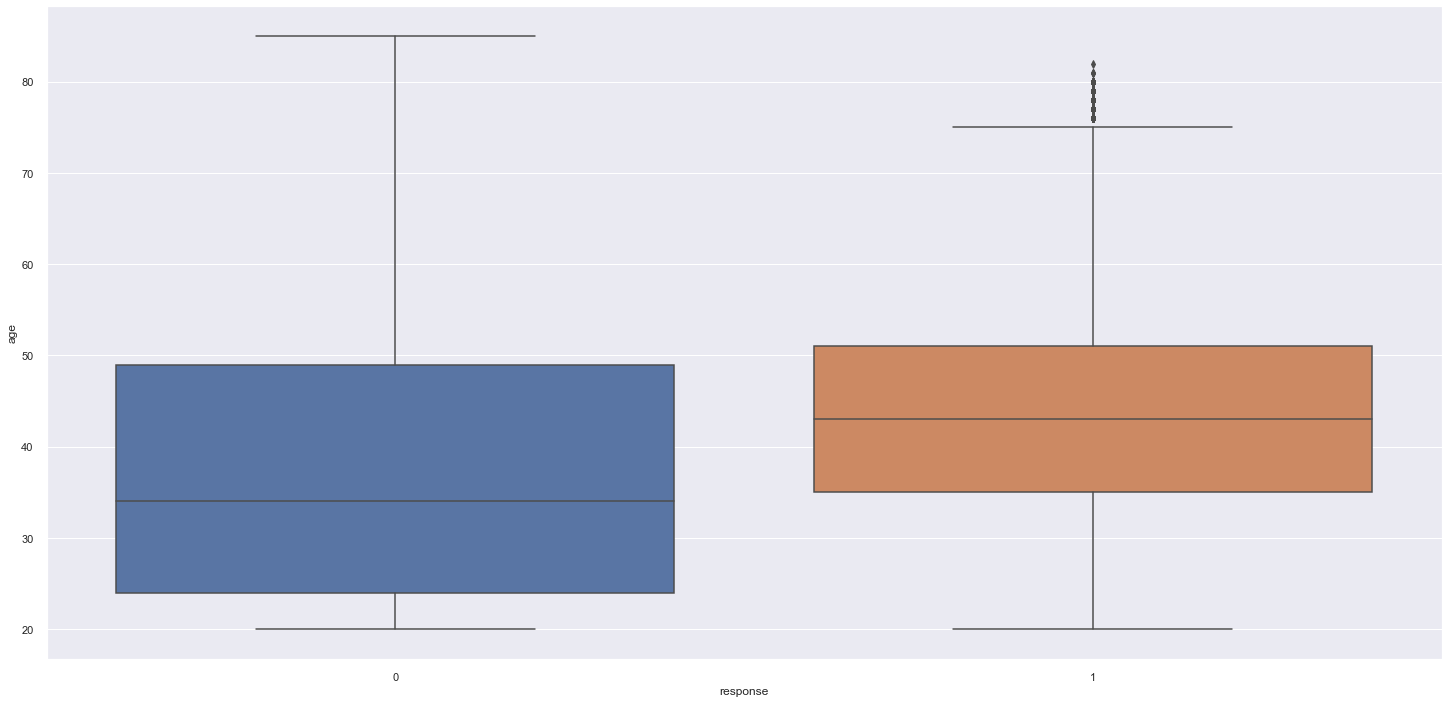

In [67]:
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot:xlabel='age', ylabel='Count'>

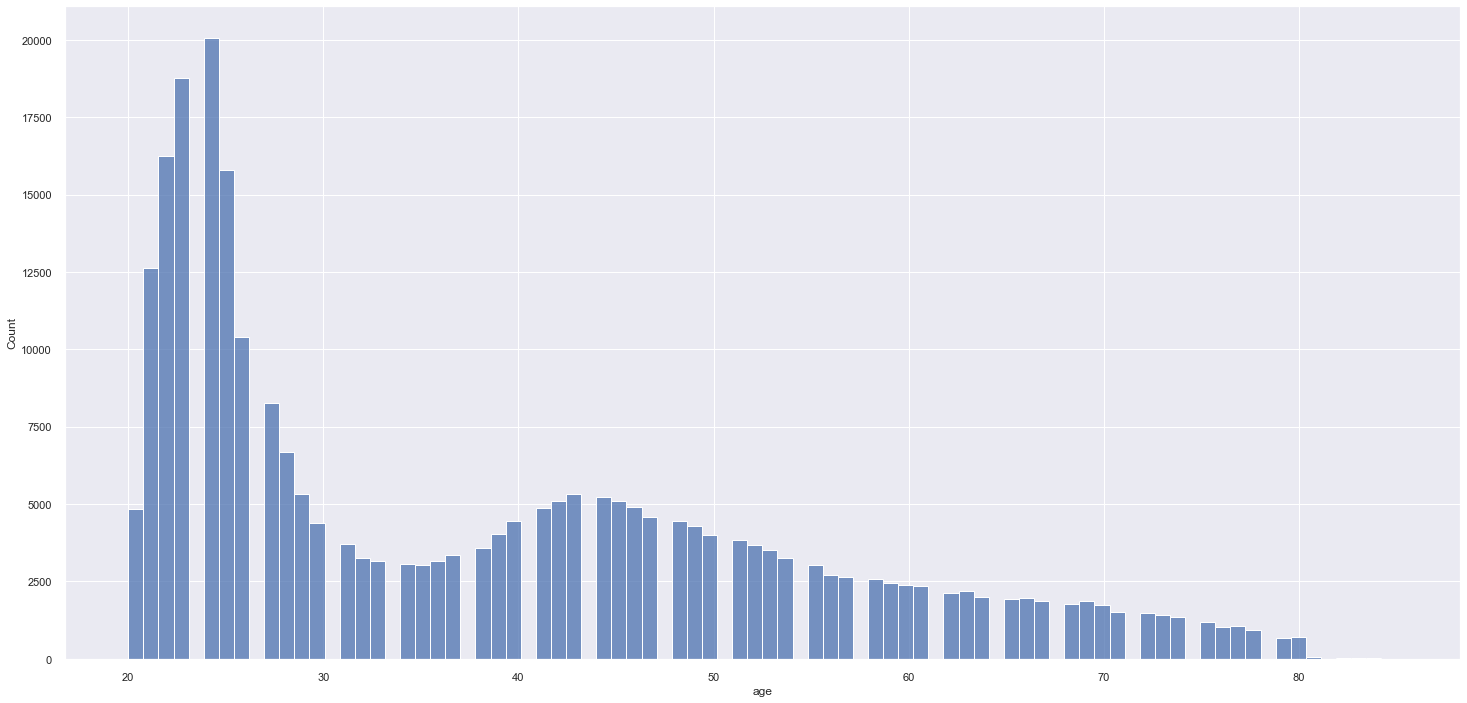

In [68]:
# Histograma de idade para respostas negativas
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

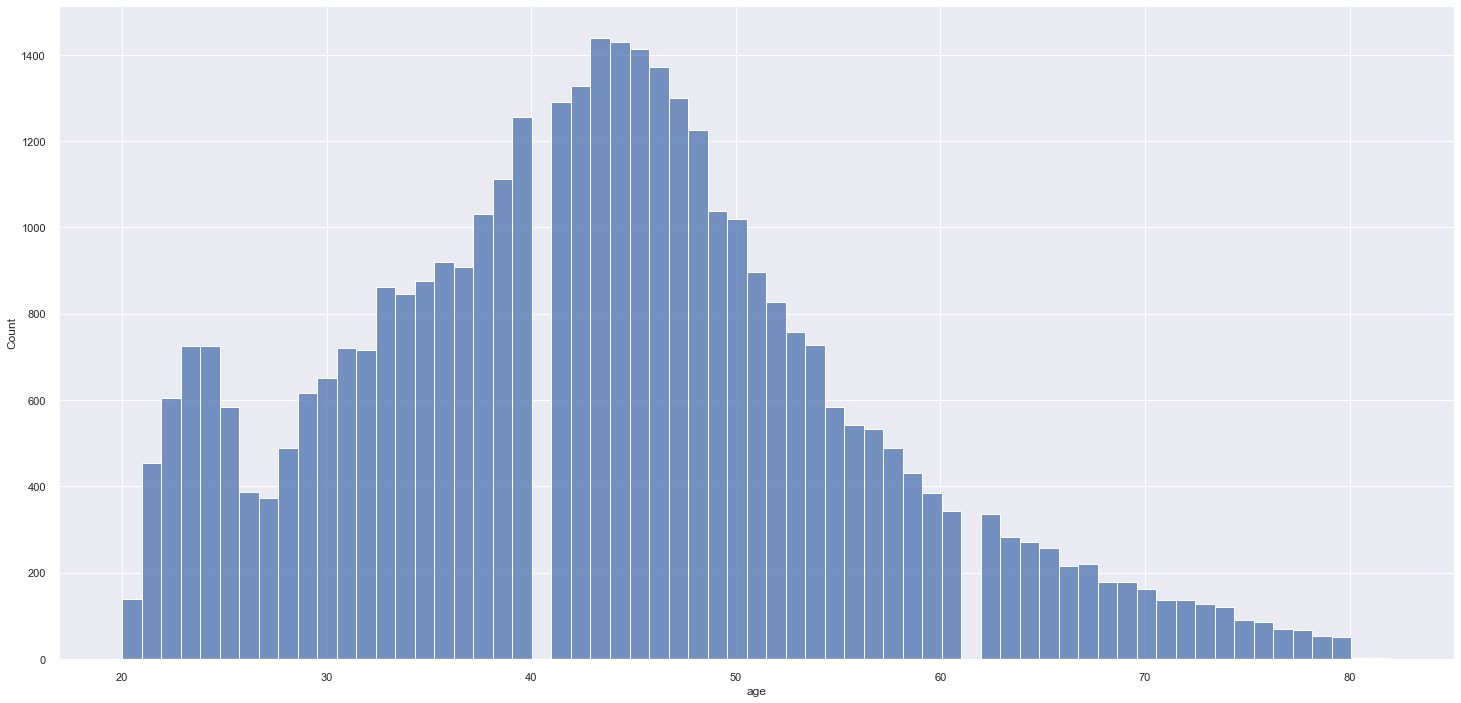

In [69]:
# Histograma de idade para respostas positivas
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

### 4.1.3. Anual Income

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

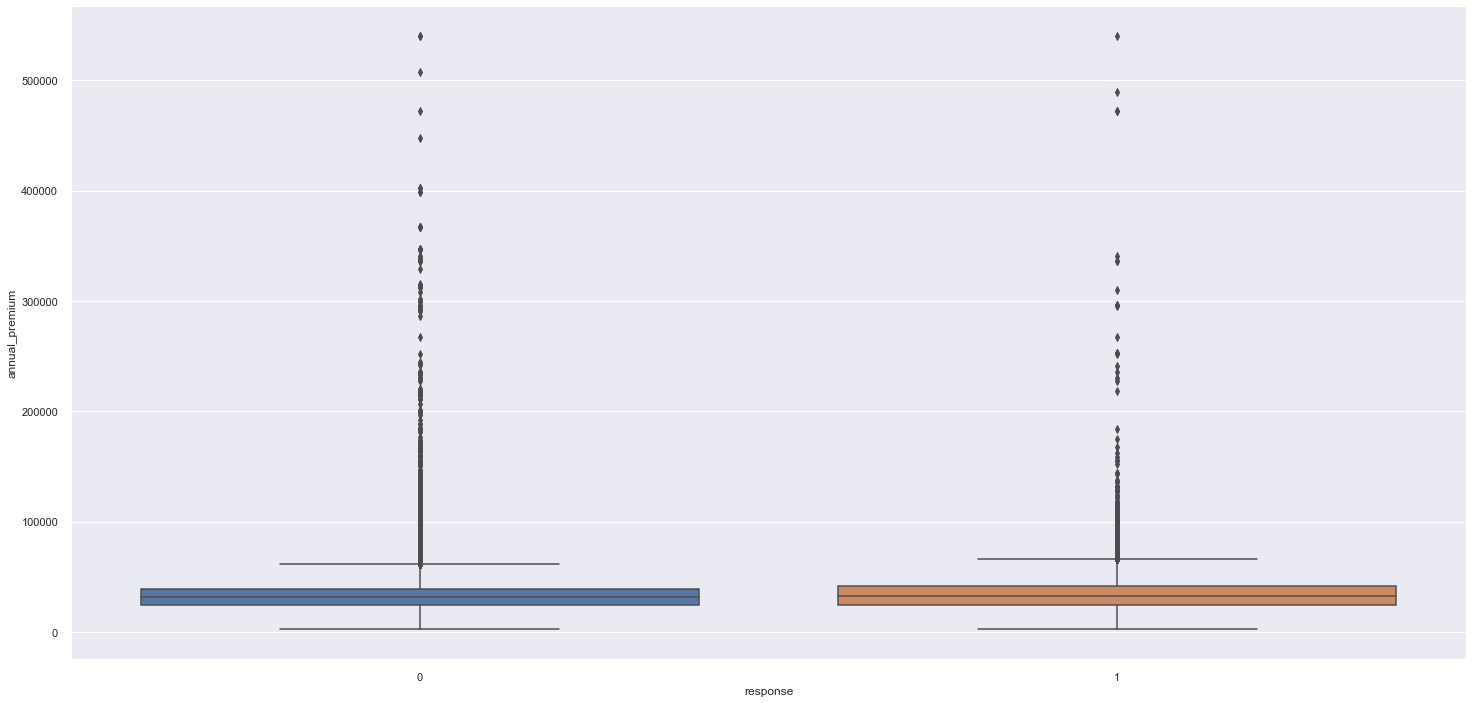

In [70]:
sns.boxplot( x='response', y='annual_premium', data=df4 )

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

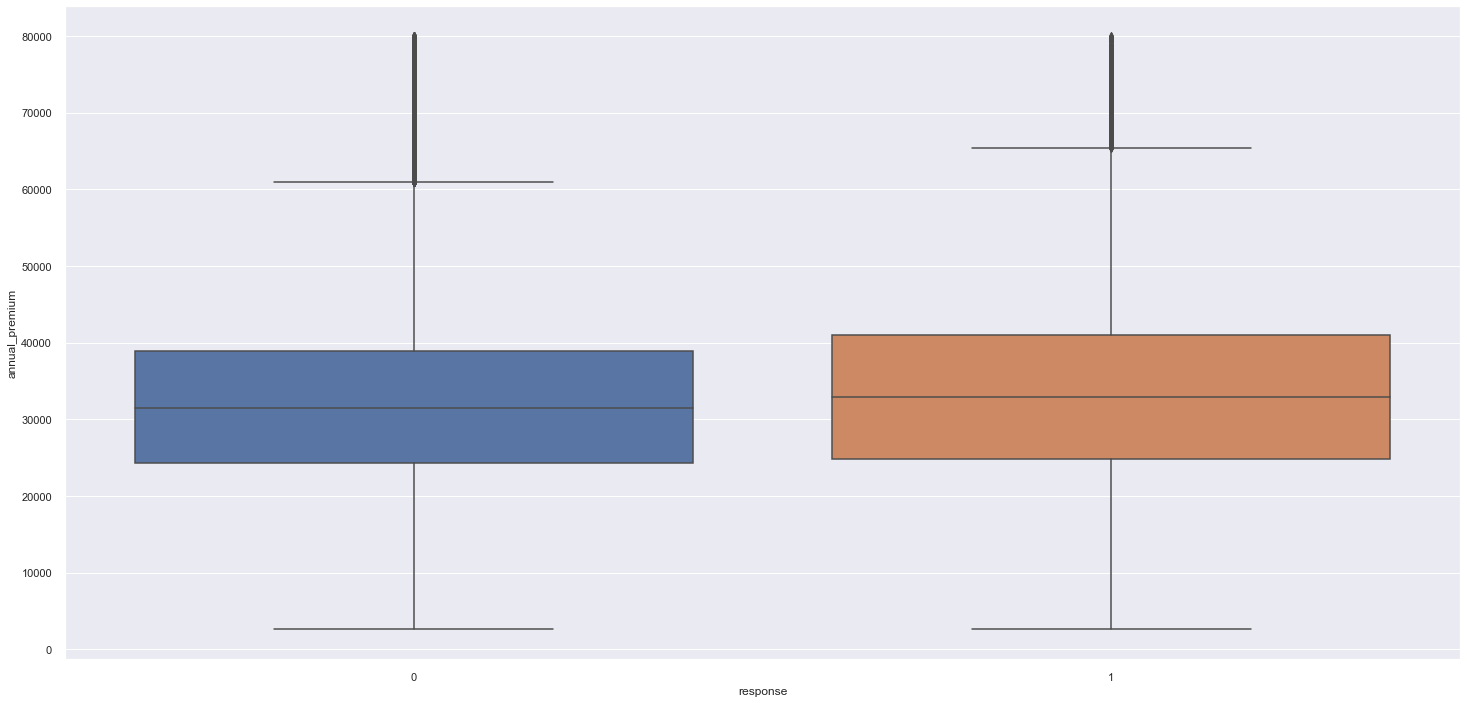

In [71]:
# Fora da margem de outliers
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

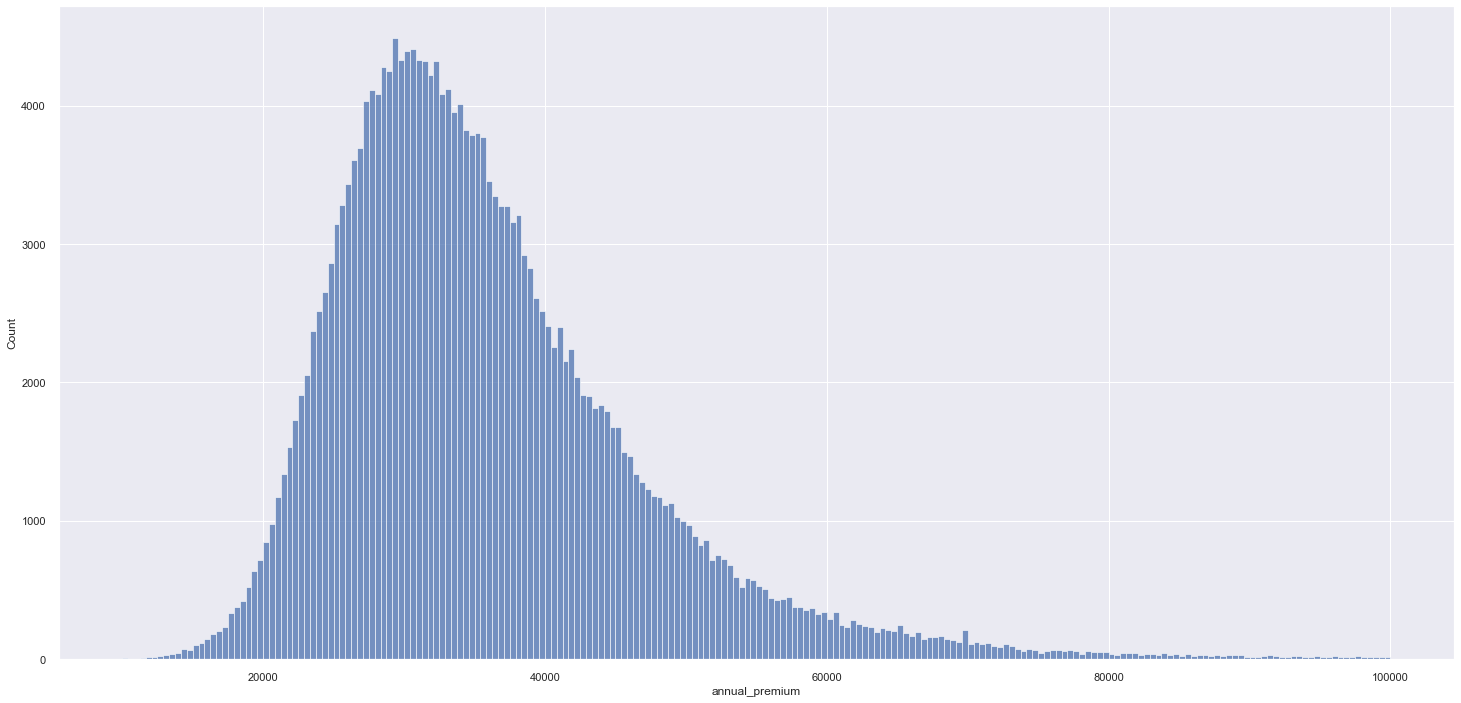

In [72]:
# Histograma para respostas negativas
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

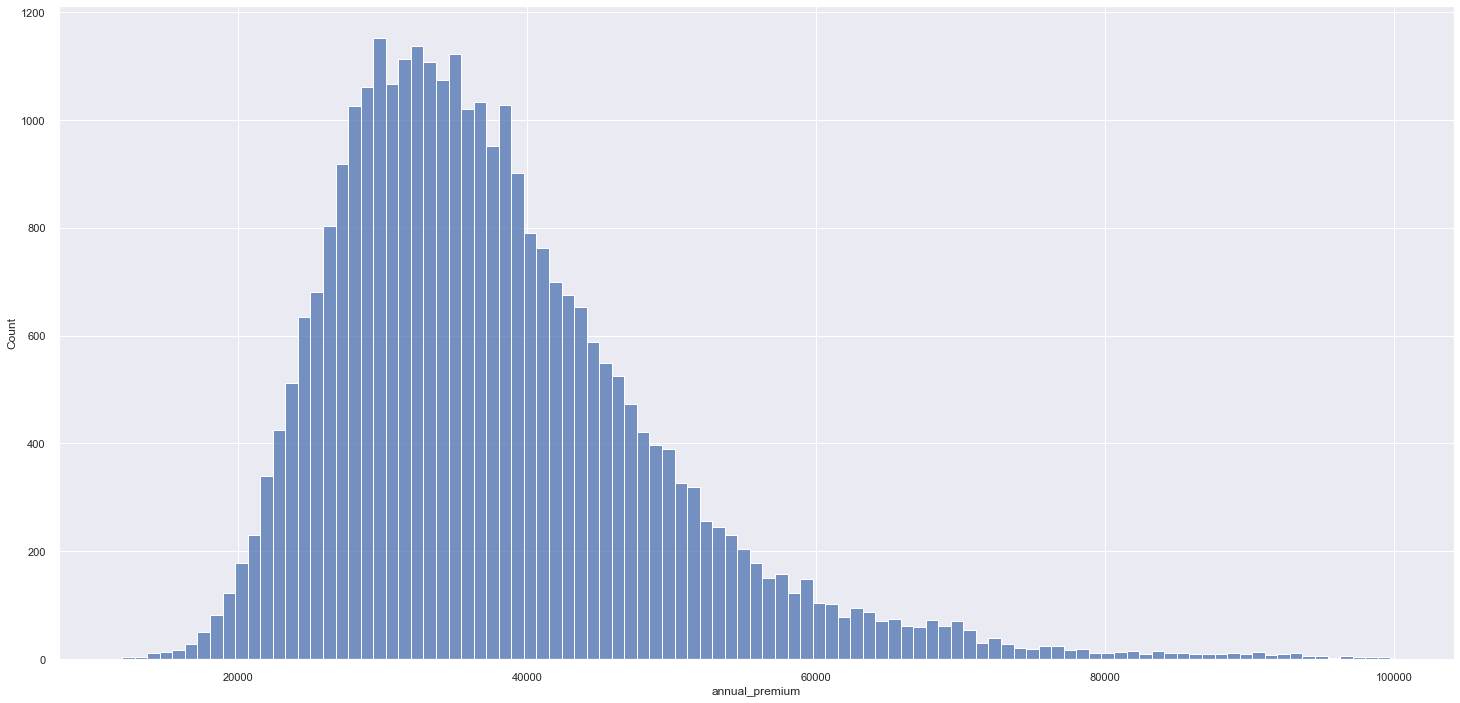

In [73]:
# Histograma para respostas positivas
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

### 4.1.4. Driving License

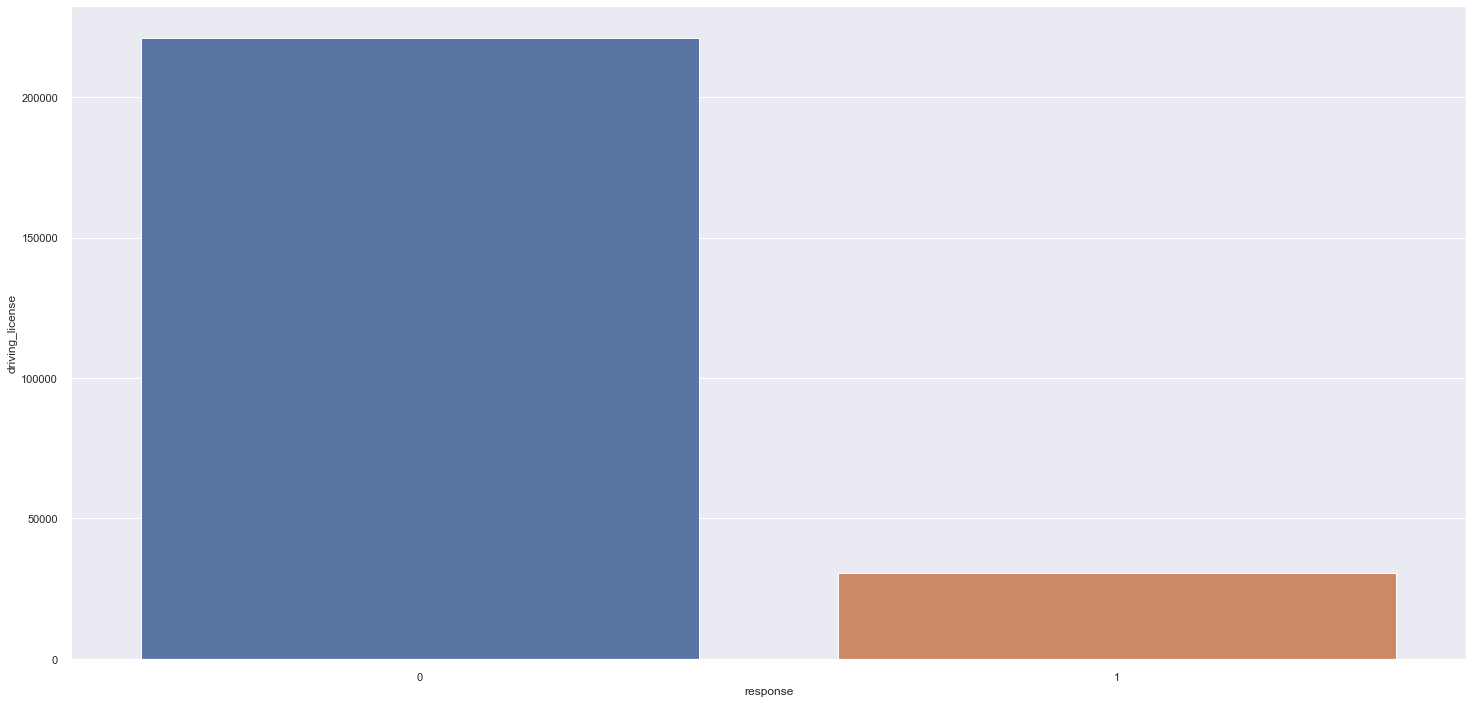

In [74]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.5. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

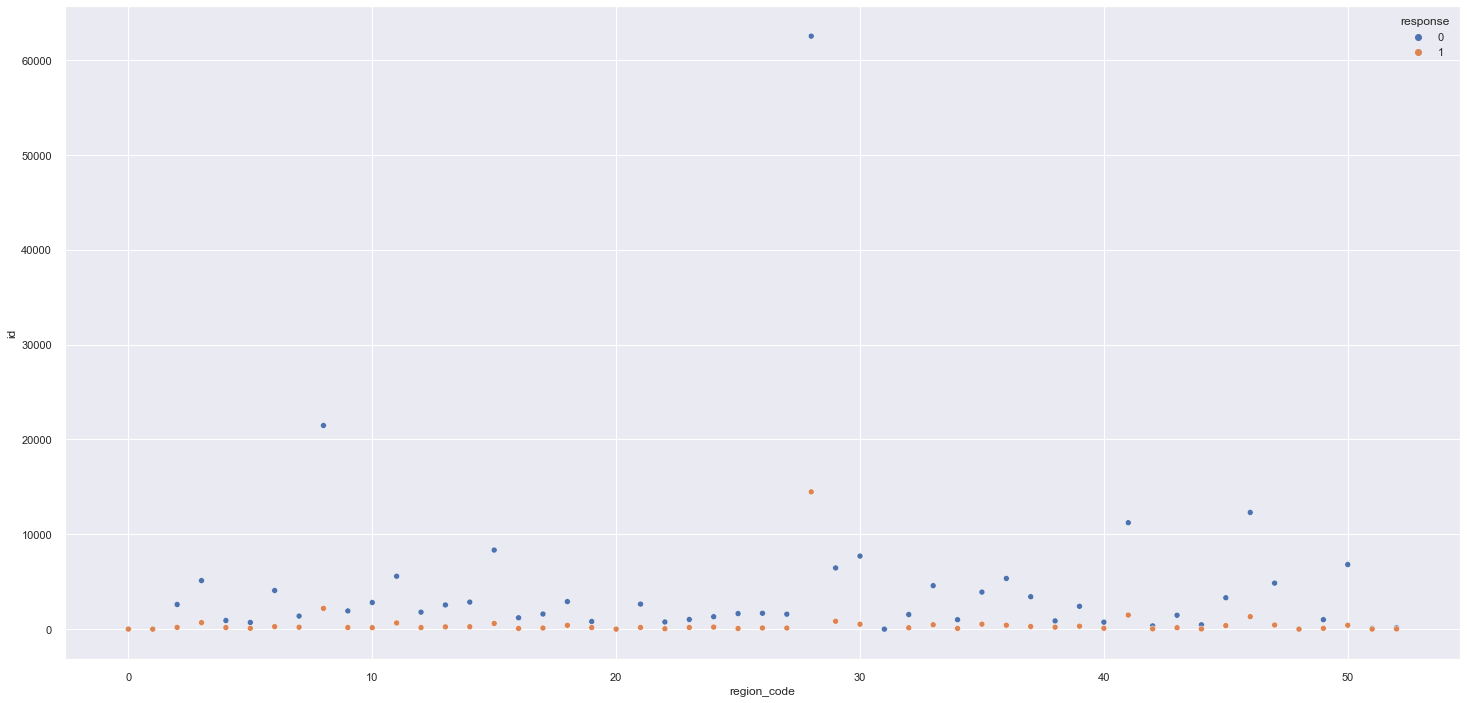

In [75]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
# aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.6. Previously Insured

In [76]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769339,0.230661
1,0.999145,0.000855


### 4.1.7. Vehicle Age

In [77]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,110178
1,below_1_year,1,4807
2,between_1_2_year,0,104281
3,between_1_2_year,1,22433
4,over_2_years,0,7279
5,over_2_years,1,3265


In [78]:
df4['vehicle_age'].unique()

array(['below_1_year', 'between_1_2_year', 'over_2_years'], dtype=object)

### 4.1.8. Vehicle Damage

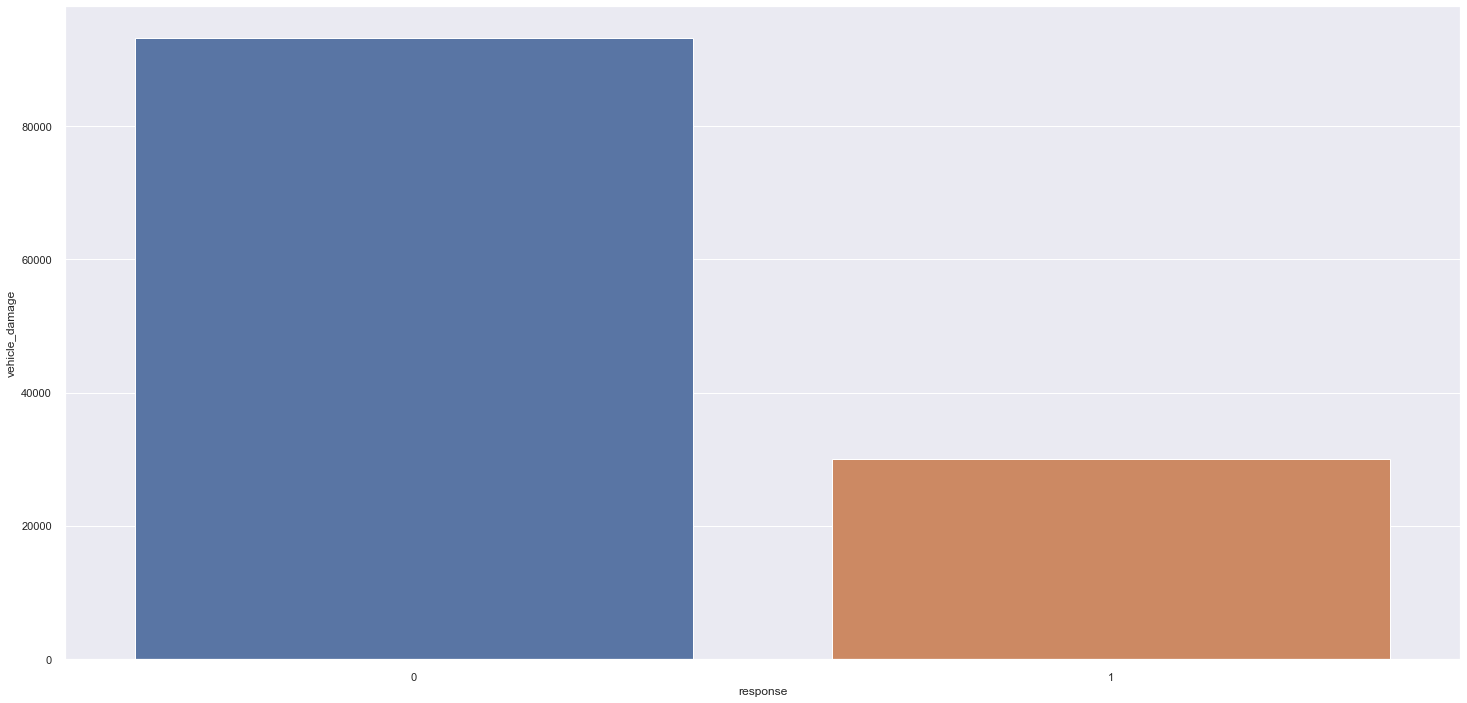

In [79]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.9. Policy Sales Channel - Stacked Percentage Bar

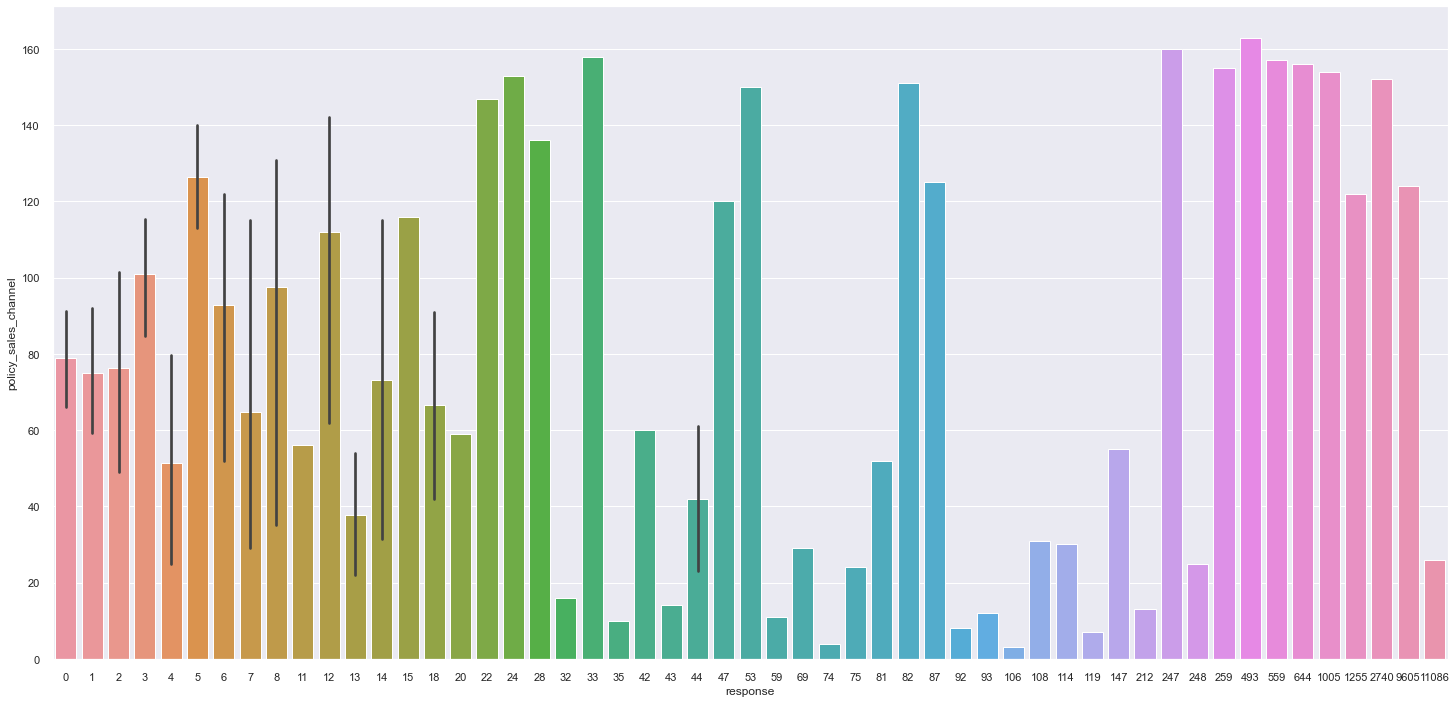

In [80]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

In [81]:
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux

,policy_sales_channel,response,total_responses
0,1.0,0,9
1,2.0,0,1
2,3.0,106,345
3,4.0,74,367
4,6.0,0,1
5,7.0,119,1062
6,8.0,92,1080
7,9.0,4,8
8,10.0,35,178
9,11.0,59,788


### 4.1.10. Vintage

<AxesSubplot:xlabel='vintage', ylabel='Count'>

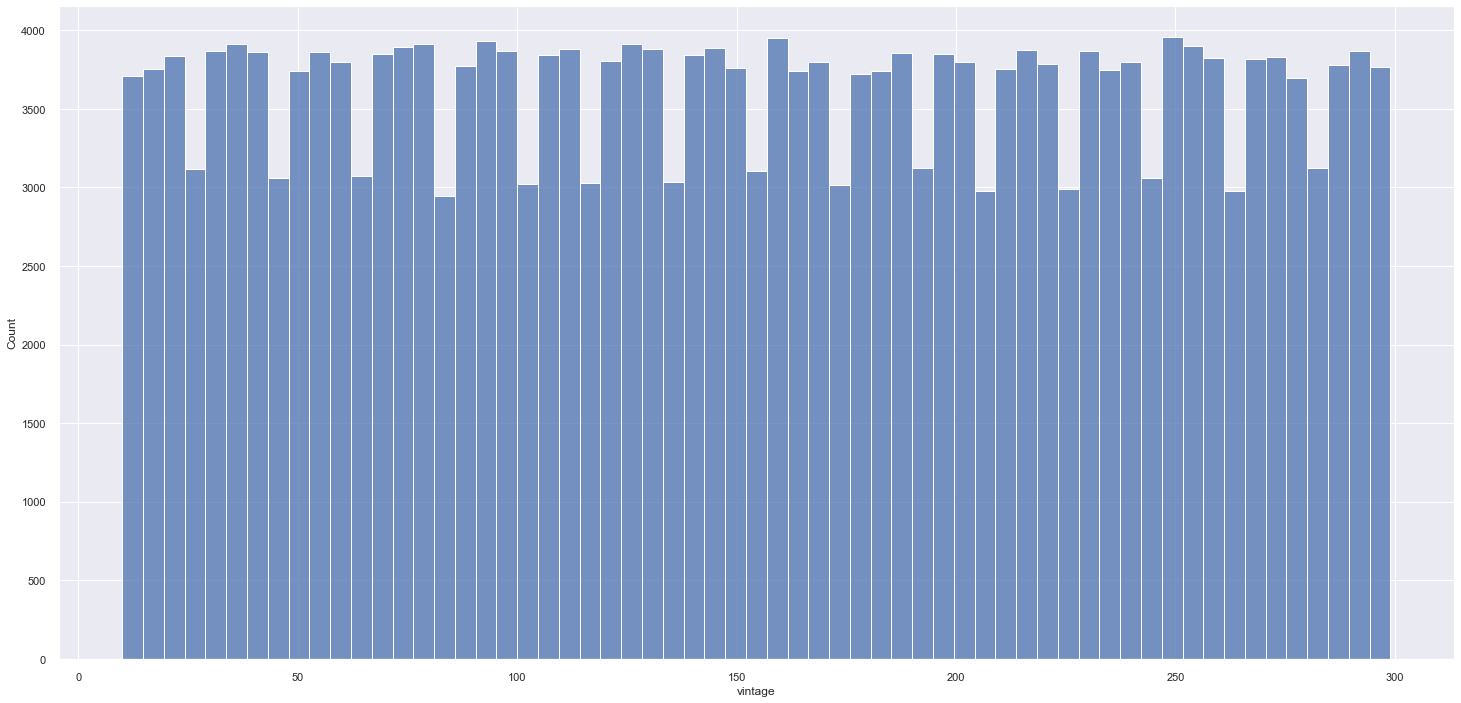

In [82]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

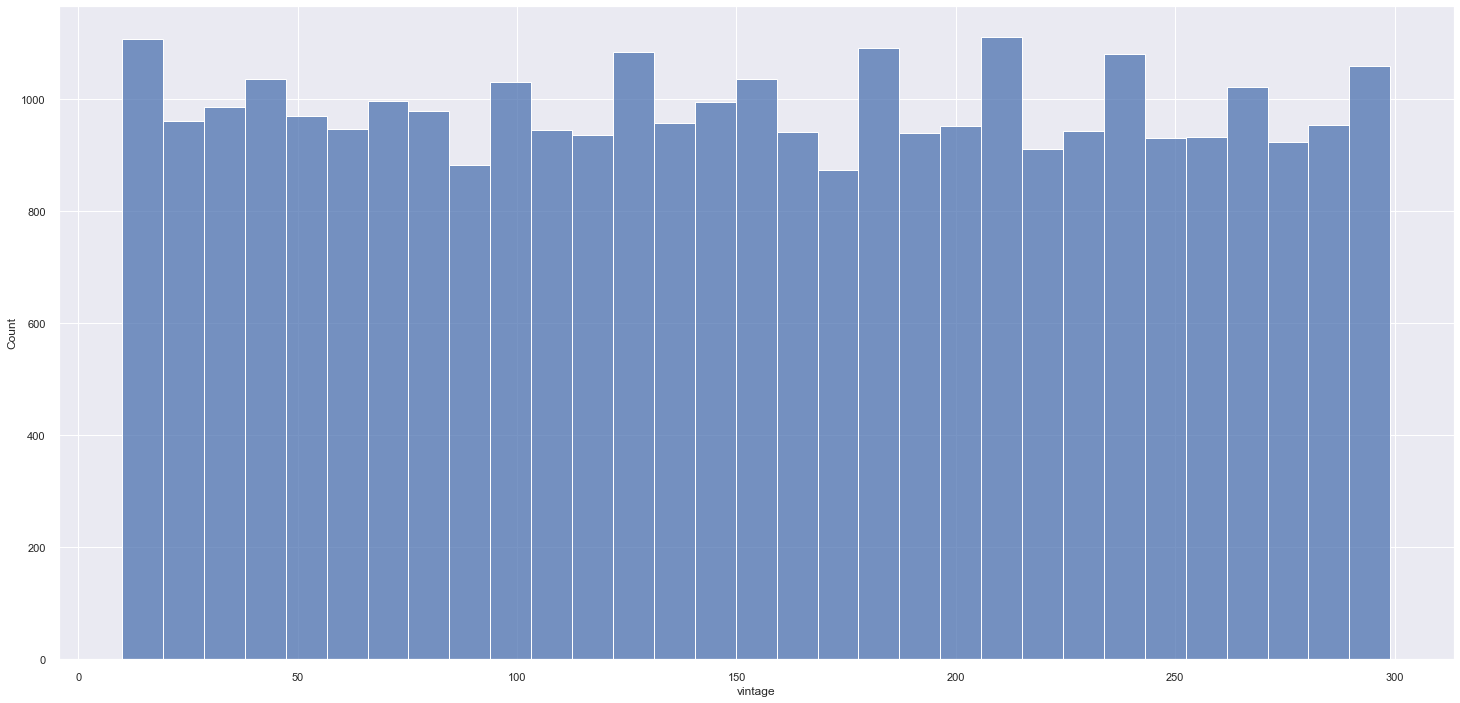

In [83]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

### 4.1.11 Gender

In [84]:
aux=df4[['gender', 'response']].value_counts( normalize=True ).reset_index()
aux.columns=[['gender','response','percentage']]
aux

,gender,response,percentage
0,Male,0,0.461107
1,Female,0,0.417958
2,Male,1,0.073976
3,Female,1,0.046959


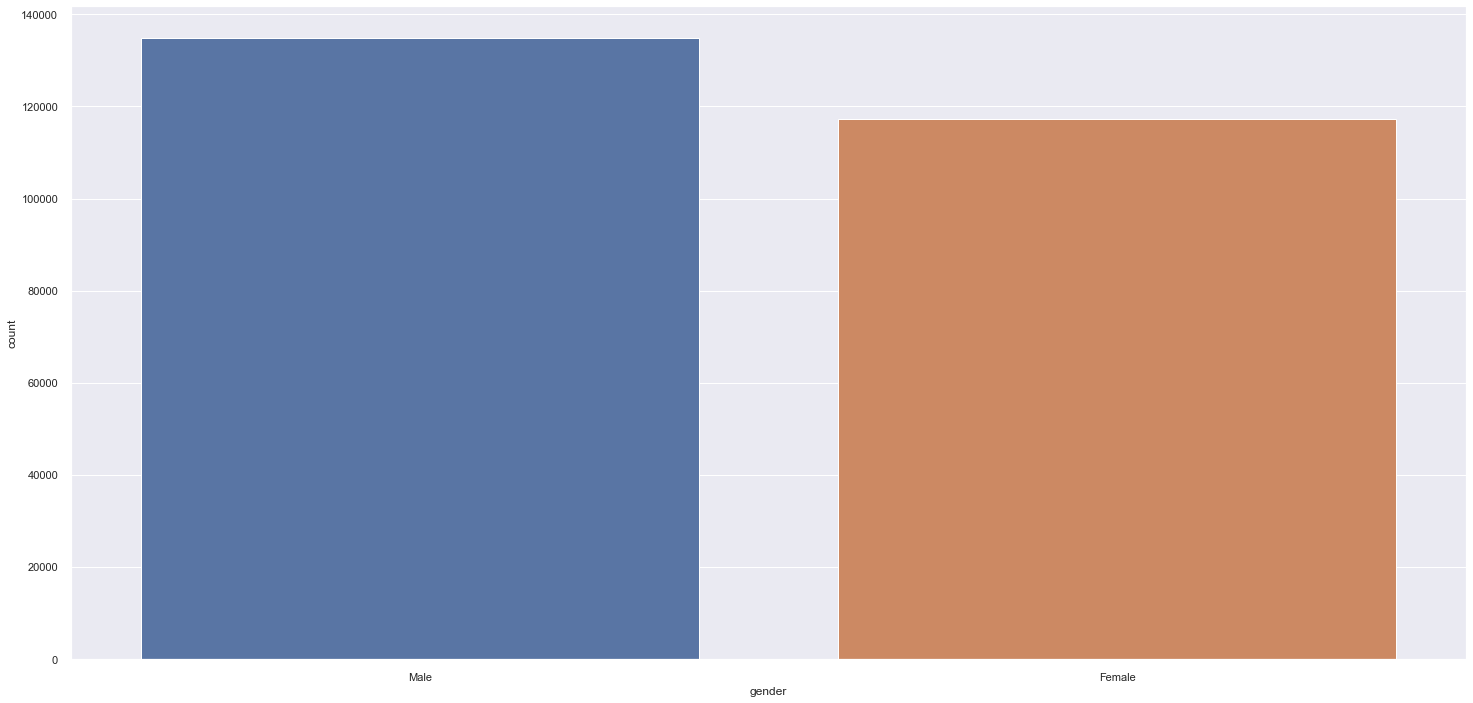

In [85]:
sns.countplot ( df4['gender']);

## 4.2 Bivariate Analysis

### **H1 -** Mulheres tem mais interesse em comprar seguro de veículos que homens.

**Falsa** - Homens tem mais interesse (61,17%) em comprar seguro de veículos do que mulheres (38,83%) 

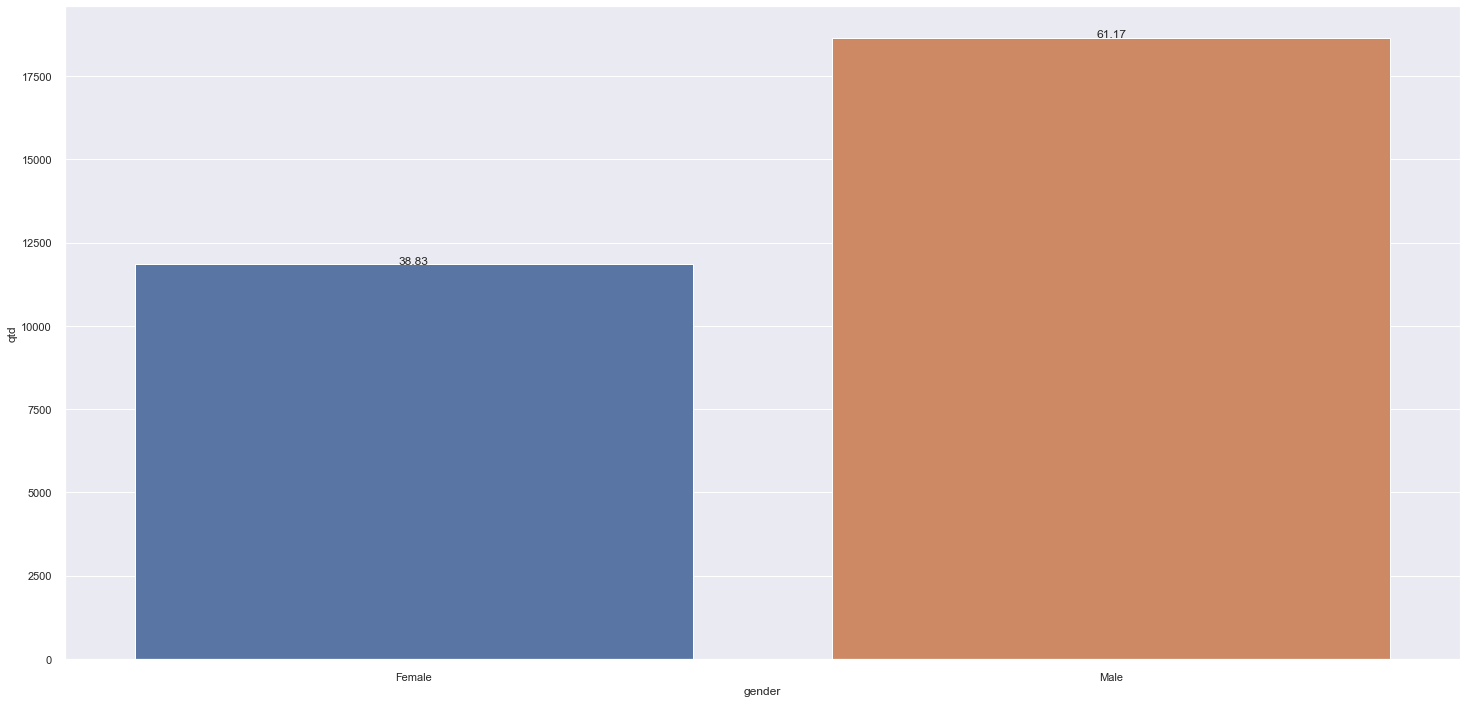

In [86]:
aux=df4[df4['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H2 - Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.

**Verdadeira** - Cliente com carros seminovos e novos correspondem a aproximadamente 90% dos interessados em adquirir um seguro de veículo


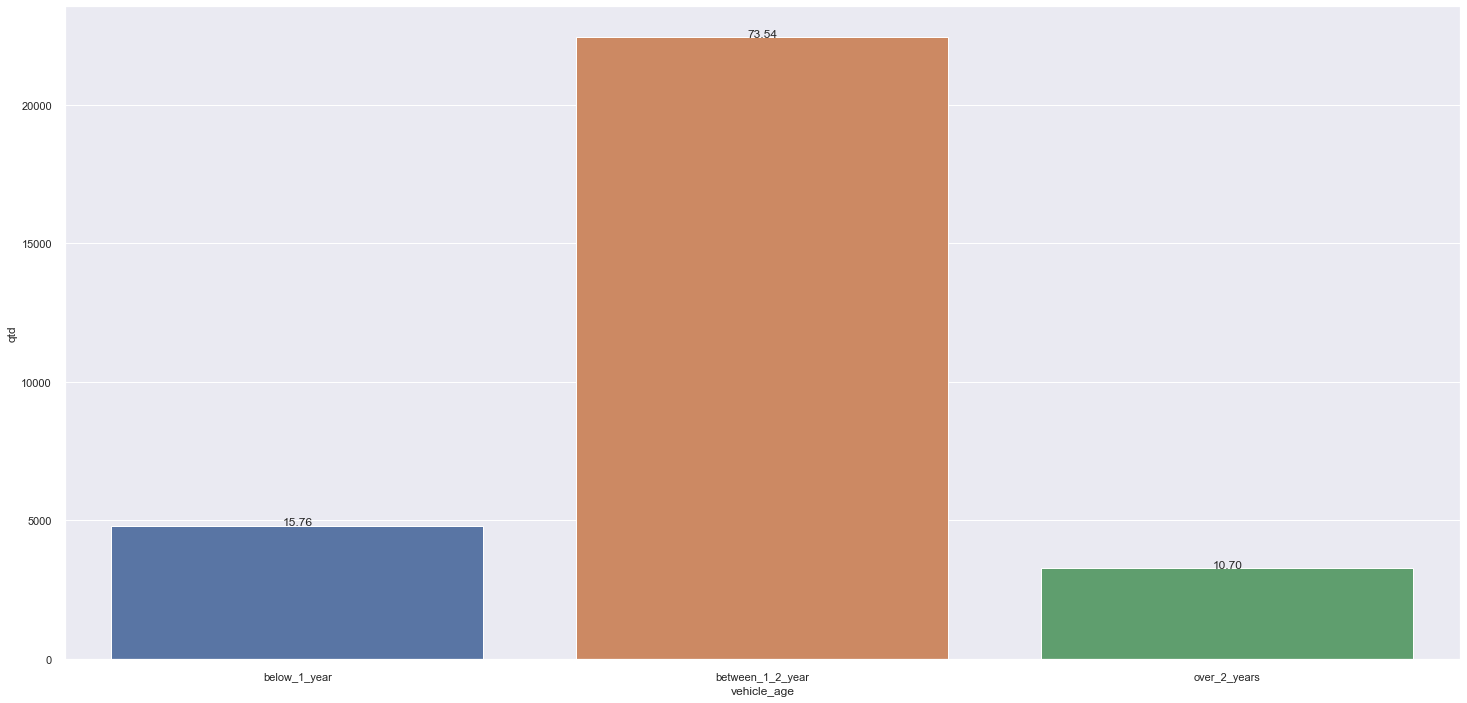

In [87]:
aux=df4[df4['response']==1]
aux=aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicle_age',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H3 - Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.

**Falsa** - Uma pequena parcela de pessoas (0.01%), embora não tenham carteira de motorista estão interessados no seguro de veículos

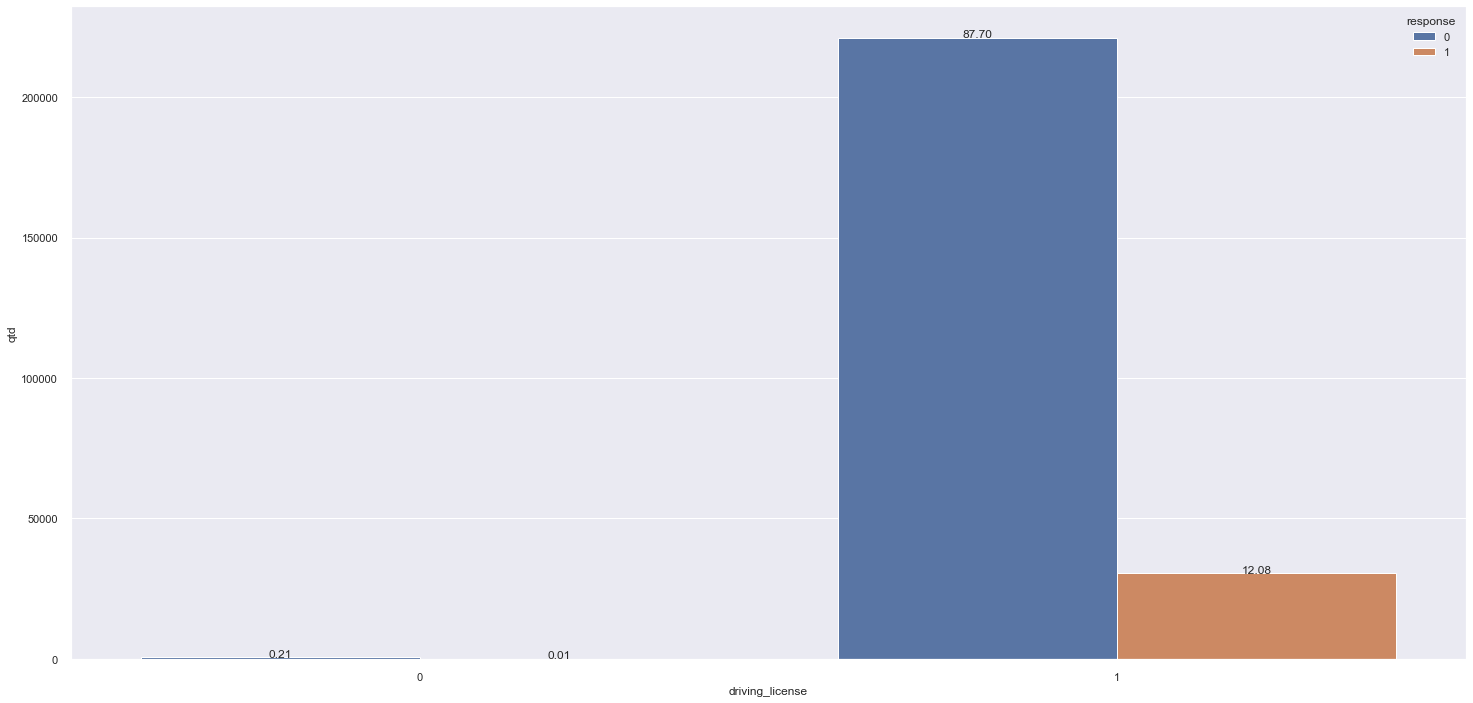

In [89]:
aux=df4[['driving_license','response']].groupby(['driving_license','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

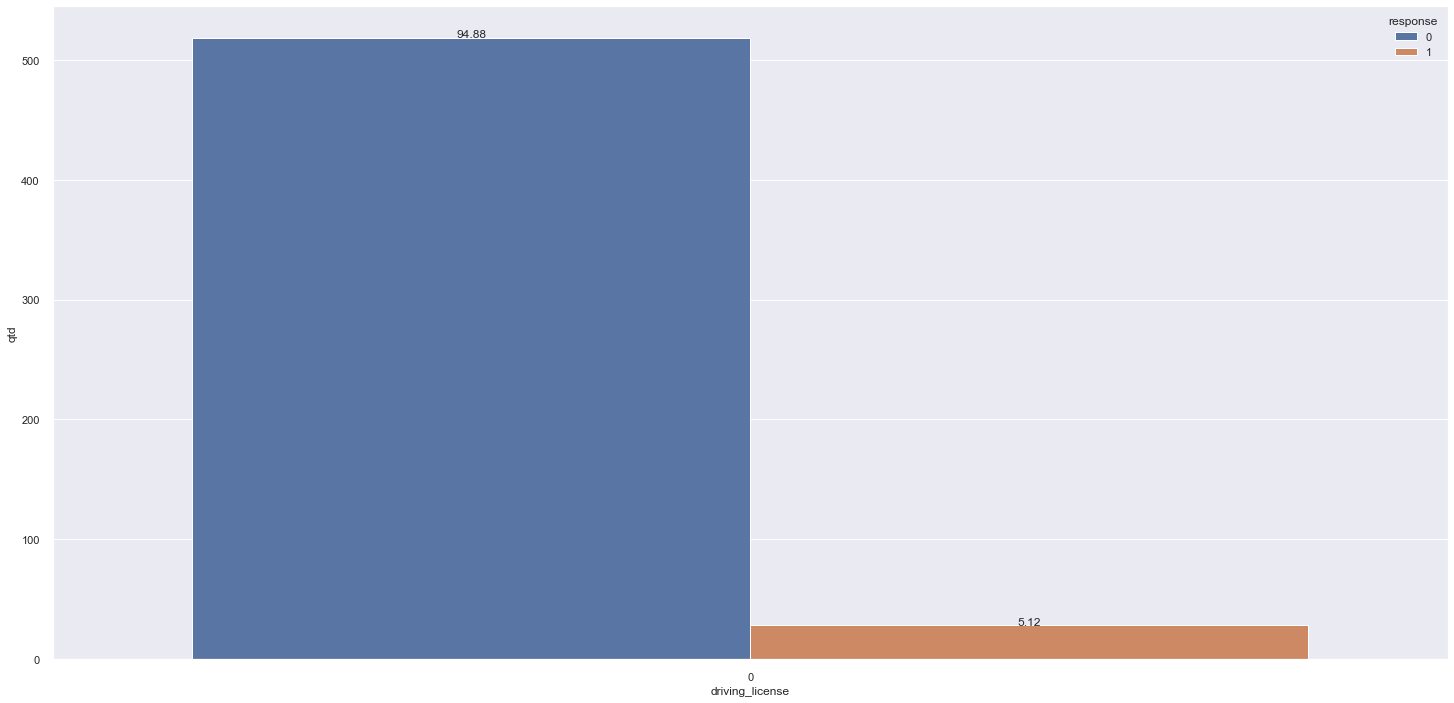

In [90]:
#Analise separada devida a pequena proporção
aux=aux[aux['driving_license']==0]
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4 - Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.

**Verdadeira** - 98% dos clientes interessados no seguro ja sofreram algum tipo de acidentes.

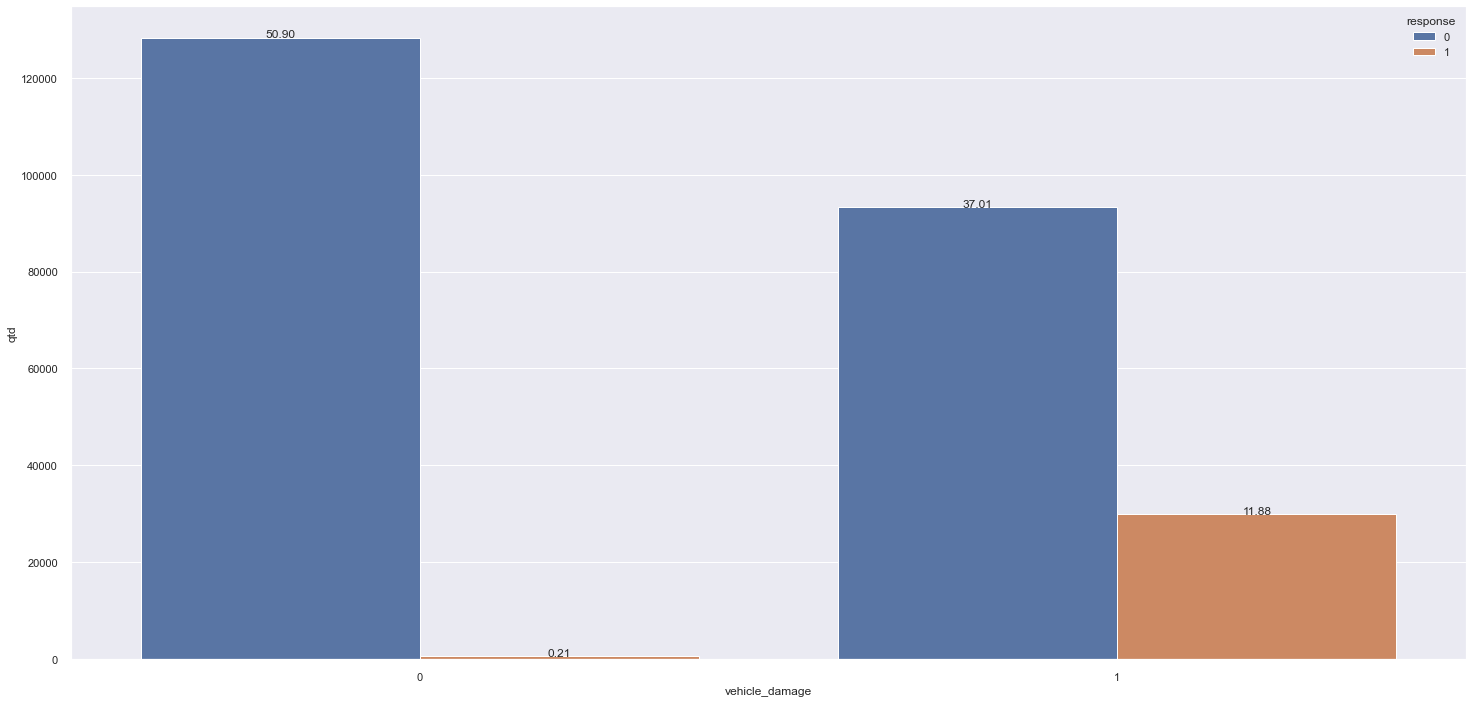

In [91]:
aux=df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

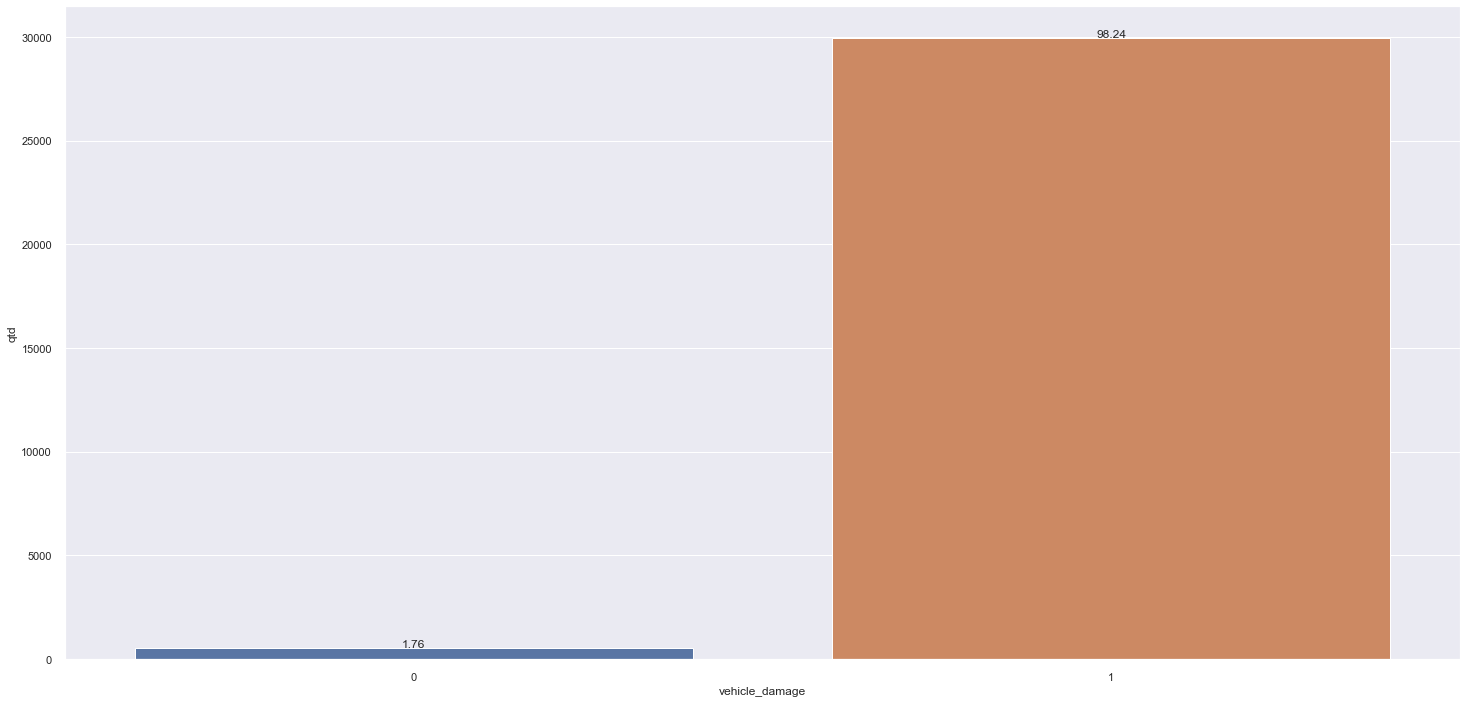

In [92]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H5 - Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos.

**Verdadeira** - Aproximadamente 87% dos clientes interessados tem mais que 30 anos de idade

<AxesSubplot:xlabel='age', ylabel='qtd'>

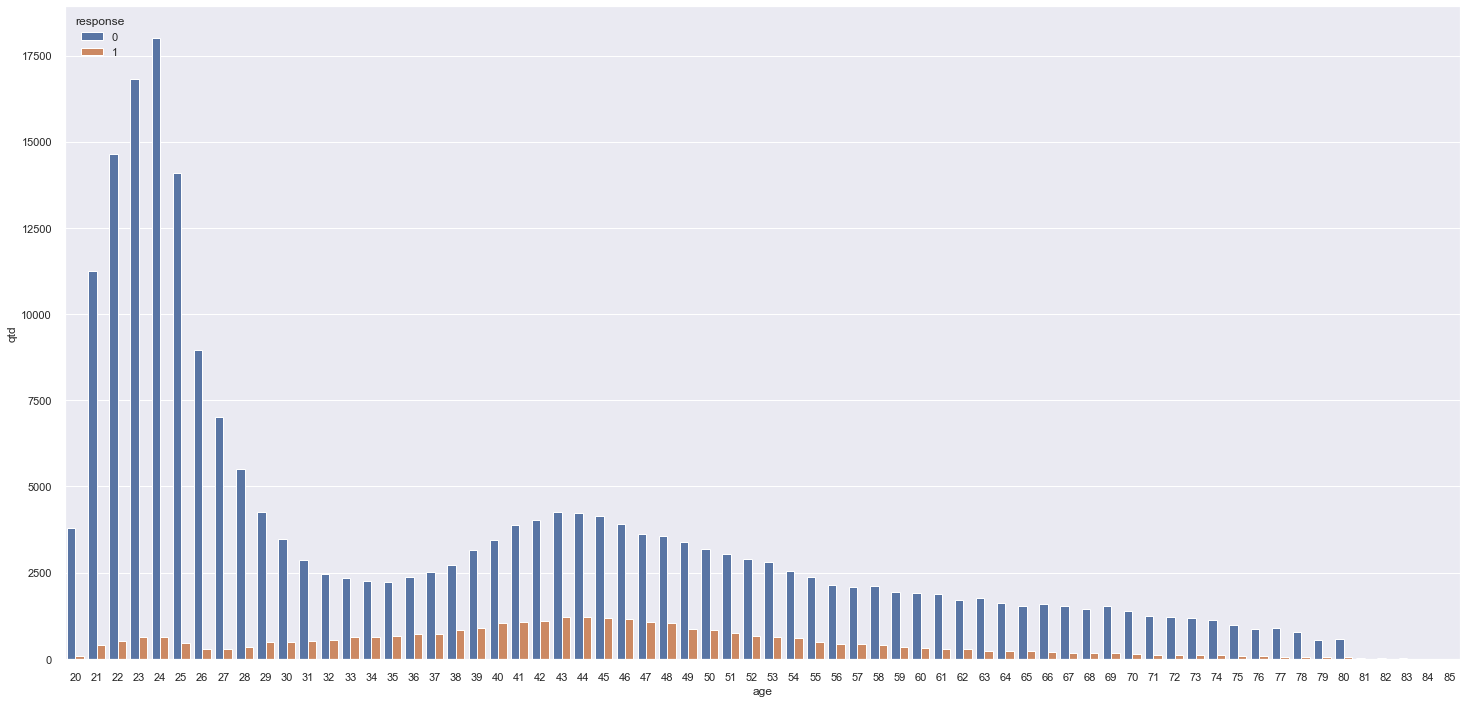

In [93]:
aux=df4[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
sns.barplot(data=aux,x='age',y='qtd',hue='response')

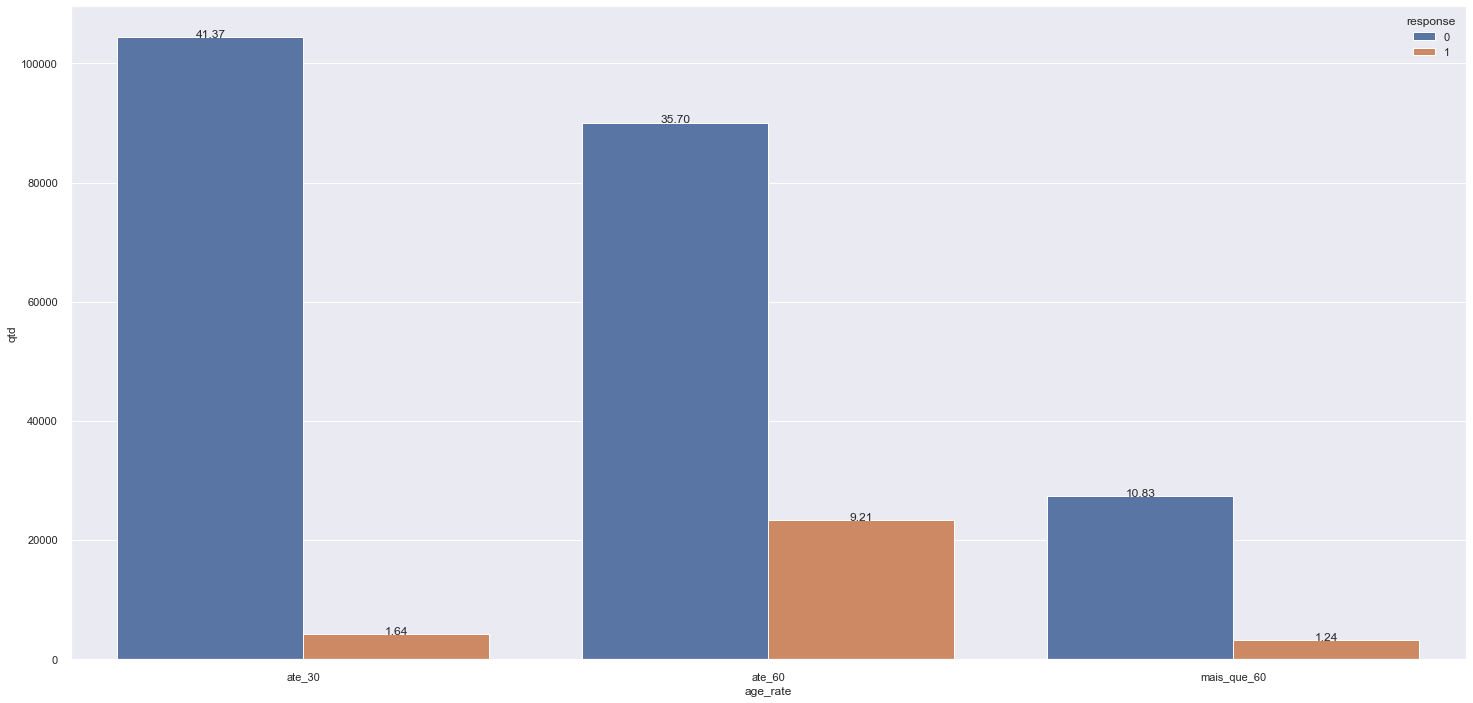

In [94]:
aux=df4.copy()
aux['age_rate']=df4['age'].apply(lambda x: 'ate_30' if x<30 else 'ate_60' if x>=30 and x<60 else 'mais_que_60')
aux=aux[['age_rate','response']].groupby(['age_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='age_rate',y='qtd',hue='response');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

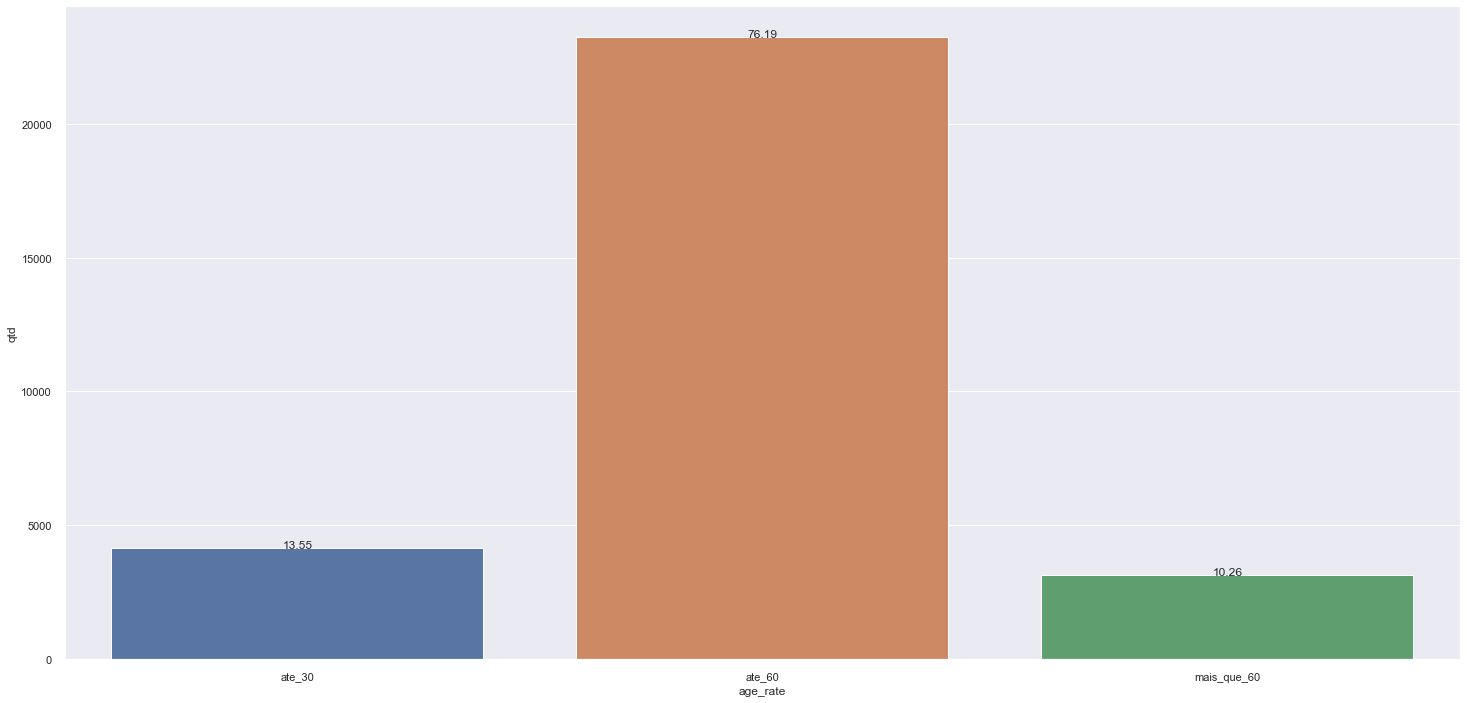

In [95]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='age_rate',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H6 - Clientes que pagaram entre 30000 e 40000 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.

**Verdadeira** - Clientes que pagaram entre 30000 e 40000 correspondem à 39,43% dos clientes interessados em seguro de veículos

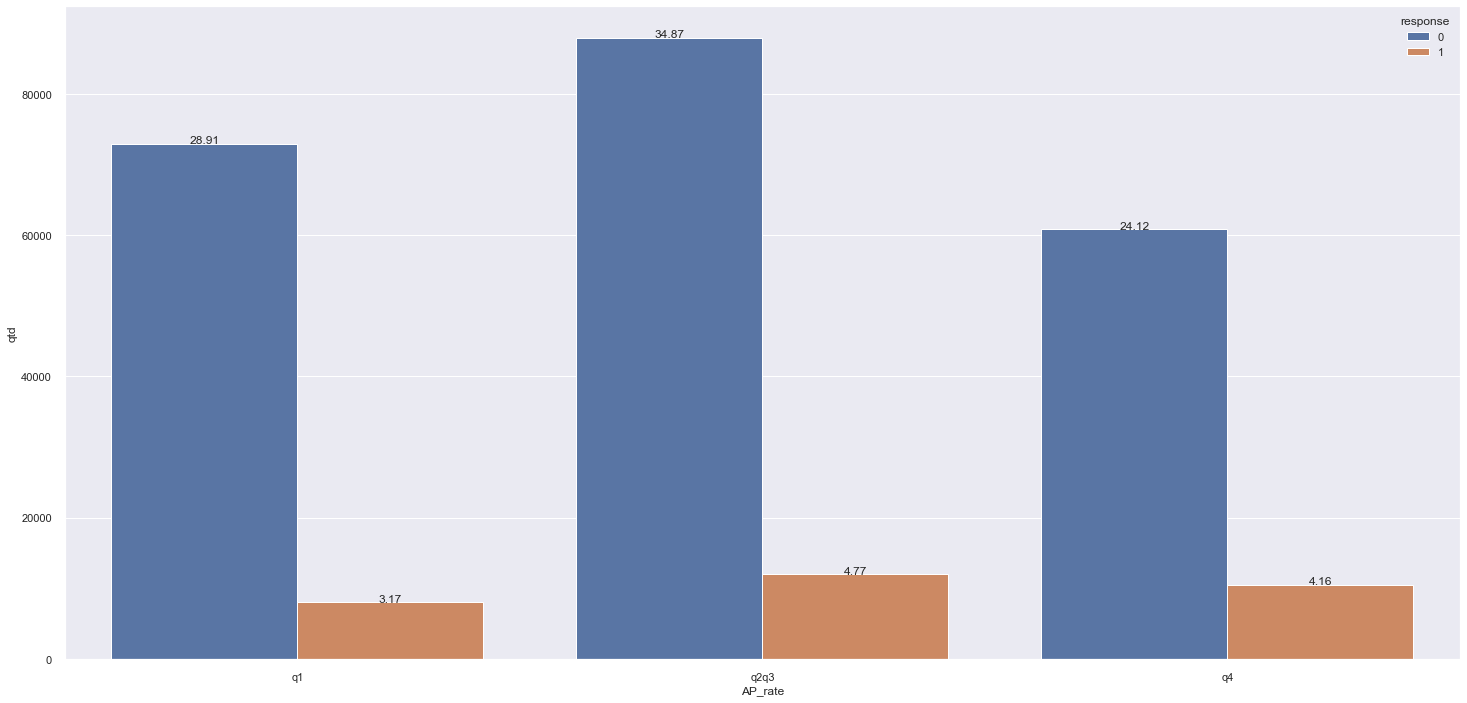

In [96]:
aux = df4.copy()
aux['AP_rate'] =aux['annual_premium'].apply(lambda x: 'q1' if x<30000 else 'q4' if x>40000 else 'q2q3')
aux=aux[['AP_rate','response']].groupby(['AP_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='AP_rate',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

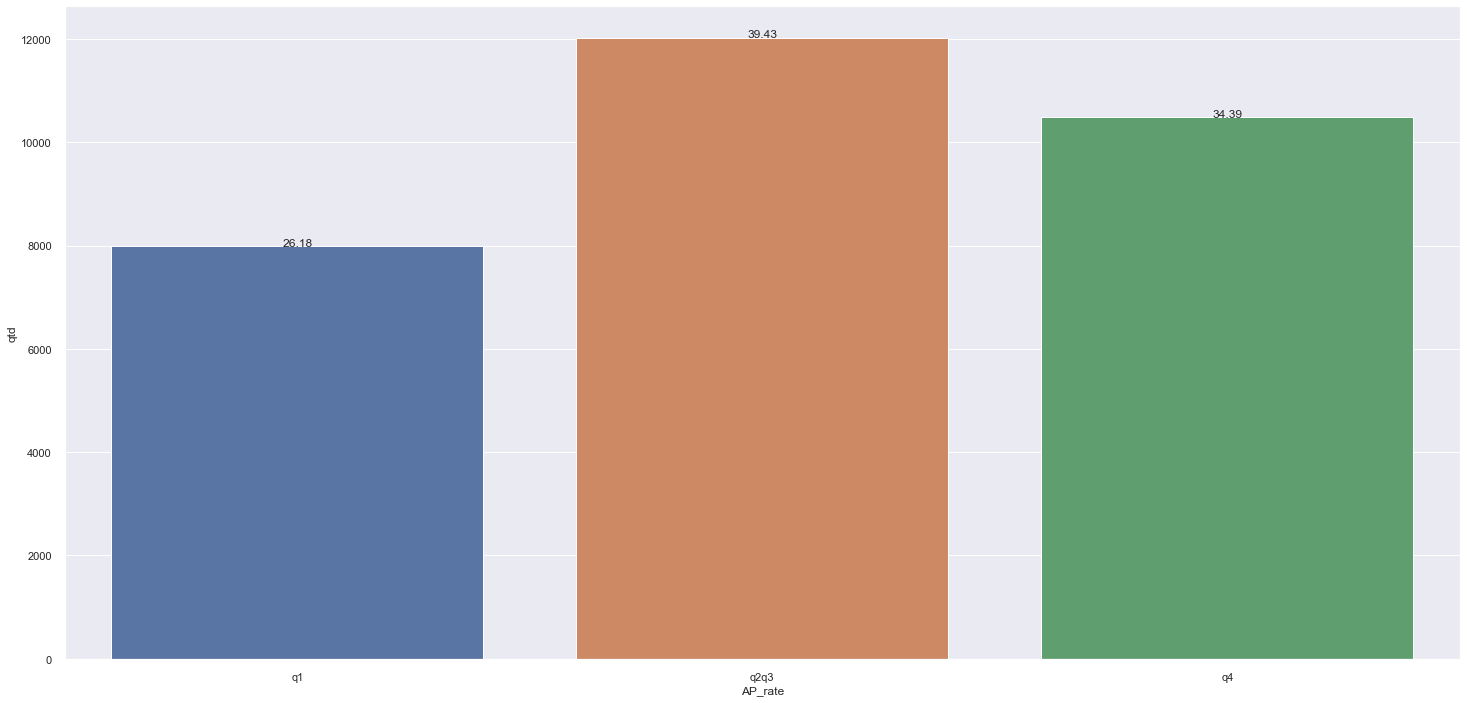

In [97]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='AP_rate',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H7 - Homens tem mais eventos de dano a veículos, do que mulheres.

**Verdadeira** - Homens representam 58,35% dos eventos de dano à veículos, enquanto as mulheres representam 41,65% dos eventos.

In [98]:
 pd.crosstab( df4['gender'], df4['vehicle_damage'] )

vehicle_damage,0,1
gender,,
Female,65915,51357
Male,63013,71958


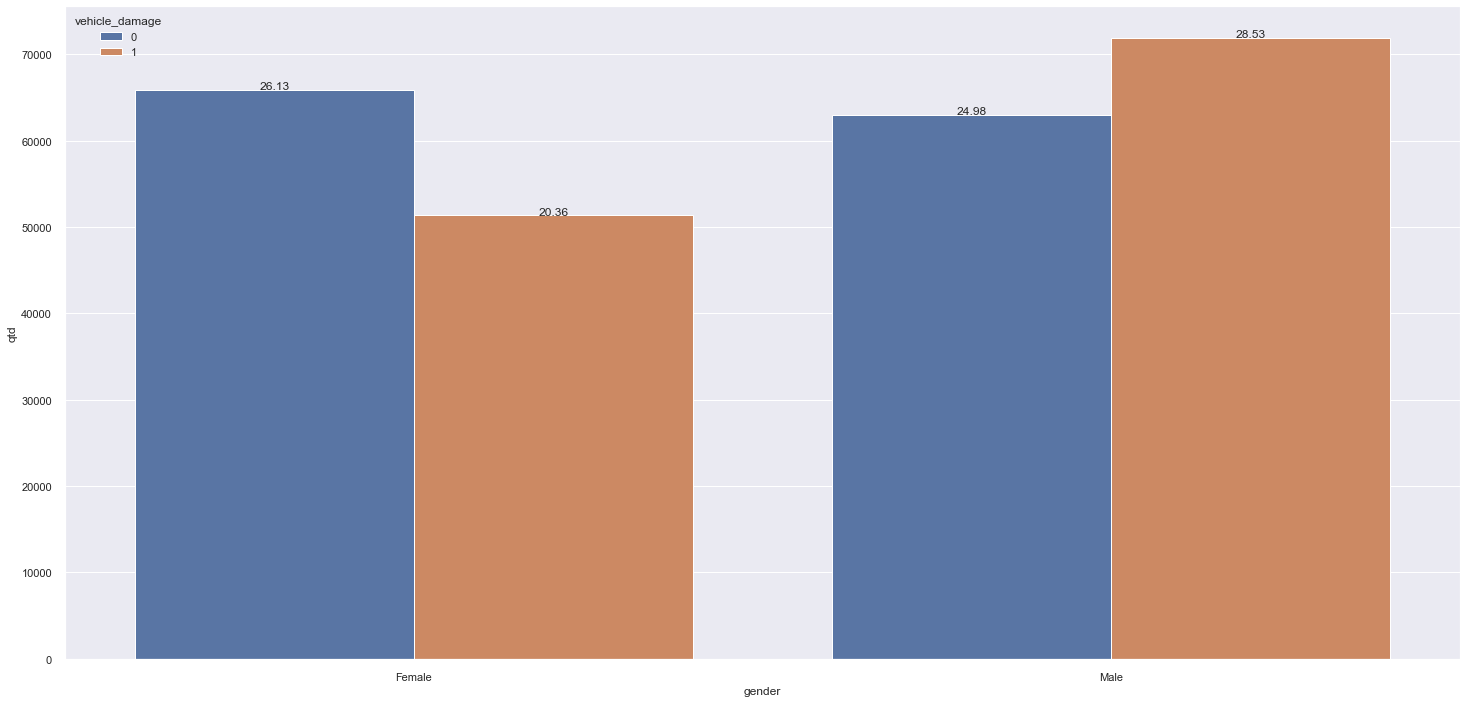

In [99]:
aux=df4[['vehicle_damage','gender']].groupby(['vehicle_damage','gender']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

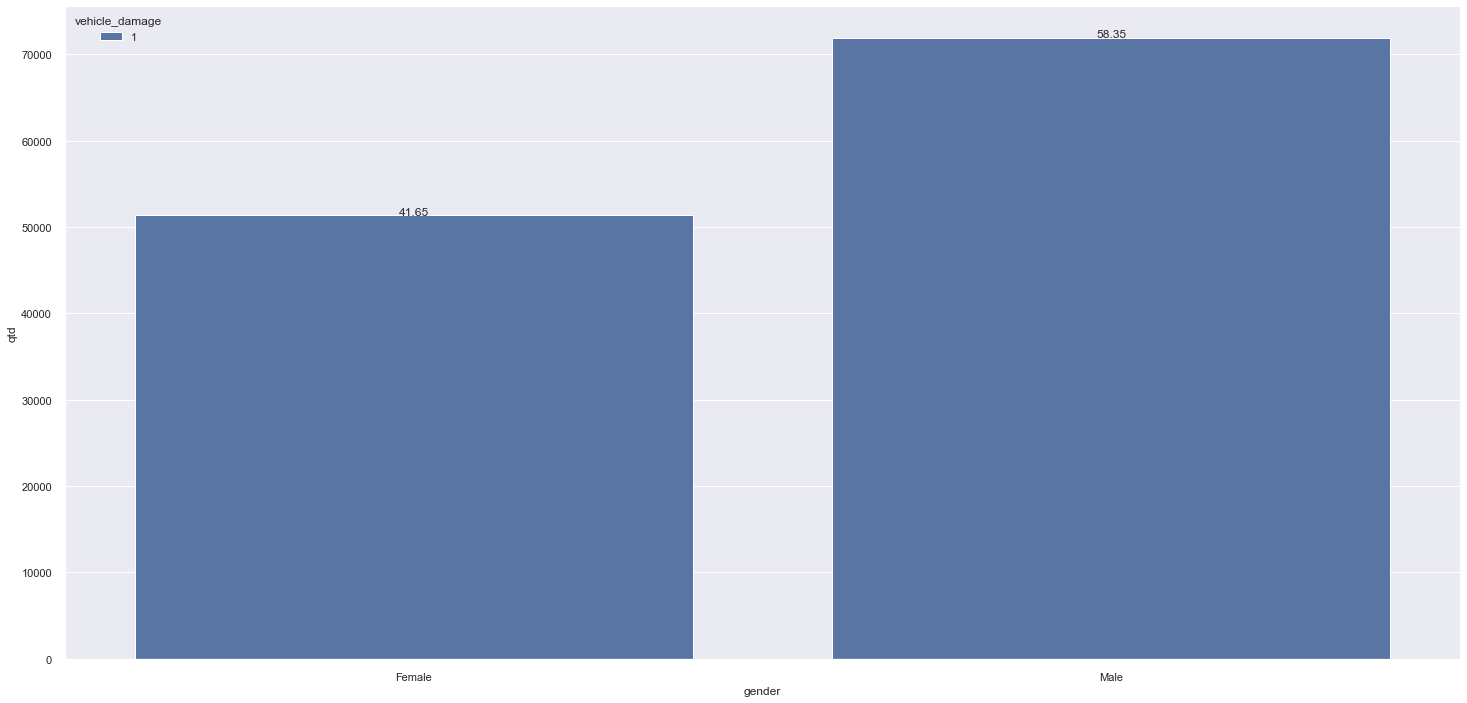

In [100]:
aux=aux[aux['vehicle_damage']==1]
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### 4.2.1 Summary of Hypotheses

In [96]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Alta'],  
      ['H2', 'Verdadeira', 'Alta'],  
      ['H3', 'Falsa', 'Baixa'],
      ['H4', 'Verdadeira', 'Alta'],
      ['H5', 'Verdadeira', 'Média'],
      ['H6', 'Verdadeira', 'Média'],
      ['H7', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Alta
H2           Verdadeira   Alta
H3           Falsa        Baixa
H4           Verdadeira   Alta
H5           Verdadeira   Média
H6           Verdadeira   Média
H7           Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.2 Numerical Attributes

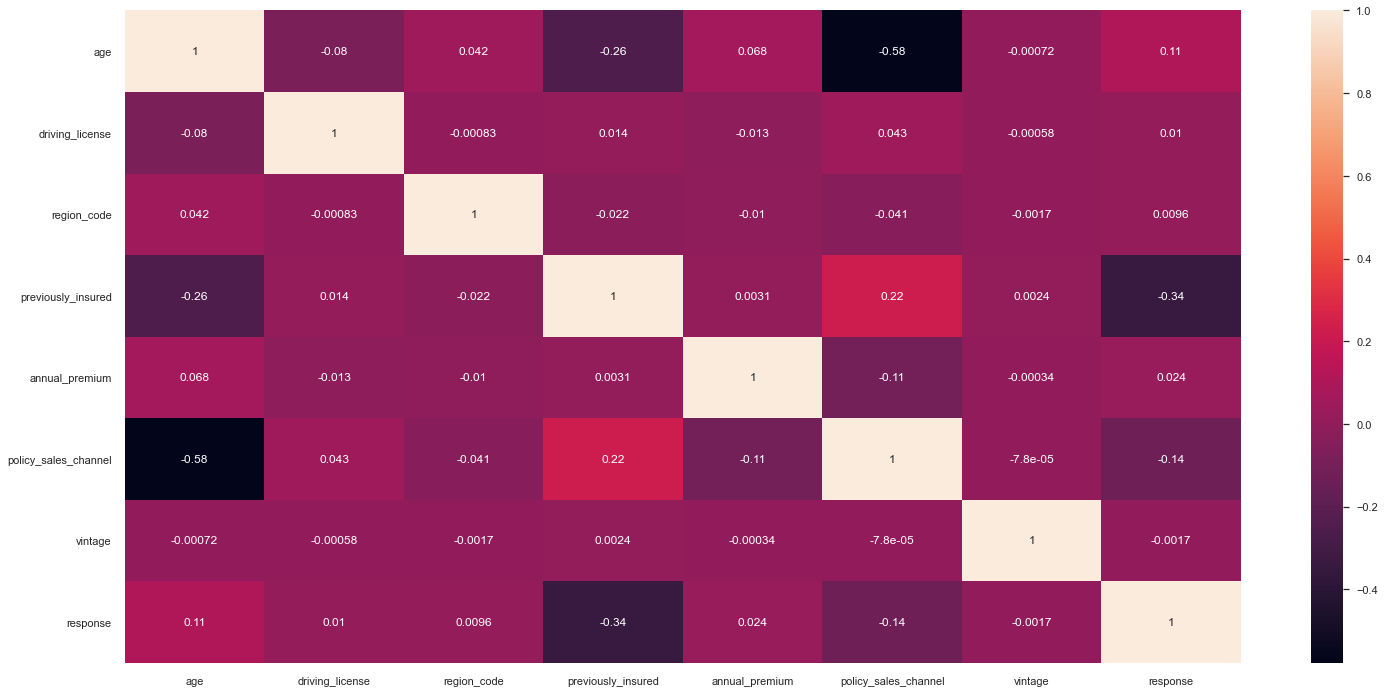

In [102]:
aux= num_attributes.corr()
sns.heatmap(aux,annot=True);

###  4.3.2. Categorical Attributes

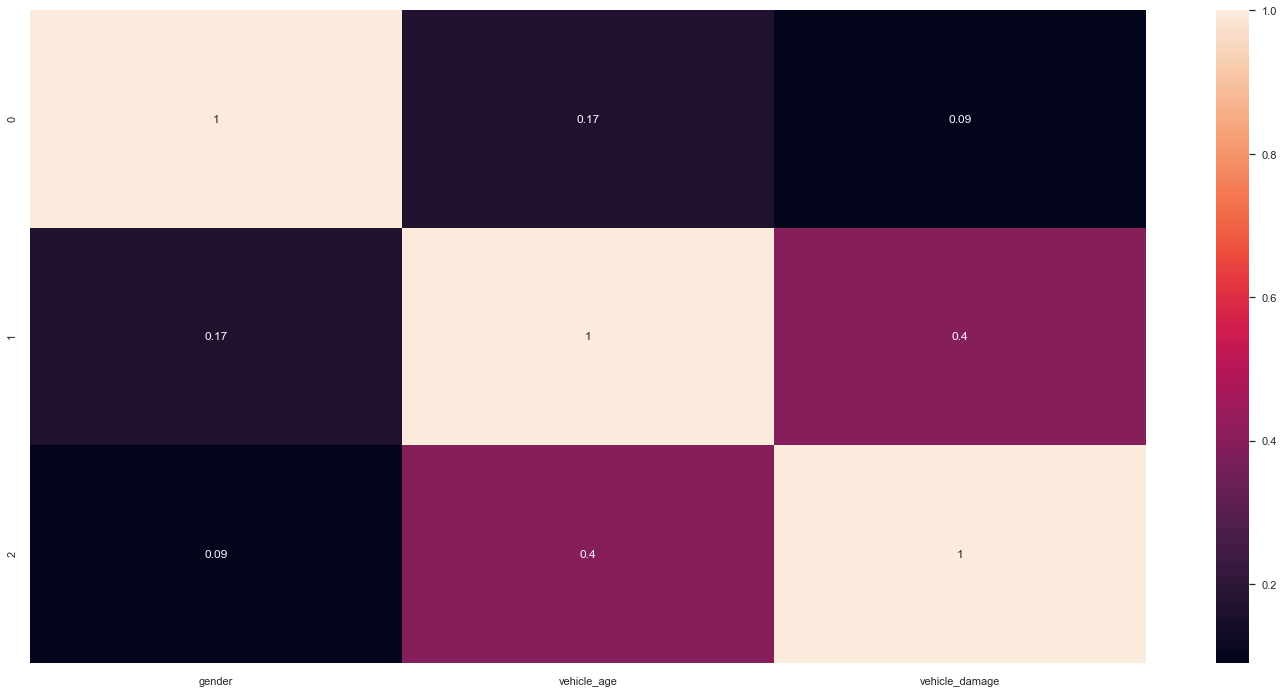

In [103]:
aux=pd.DataFrame(corr_cramer_v(cat_attributes))
sns.heatmap(aux,annot=True);

# 5.0. Data Preparation

In [22]:
df4=df3.copy()

## 5.1. Standardization

In [23]:
ss = pp.StandardScaler()


# anual premium - StandarScaler
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )
pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )


## 5.2 Rescaling

In [24]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df4['age'] = mms_age.fit_transform( df4[['age']].values )
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )


## 5.3 Transformation

### 5.3.1  One Hot Encoding

In [25]:
# gender 
target_encode_gender = df4.groupby( 'gender' )['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# vehicle_age 
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )


### 5.3.2 Targe Encoding

In [26]:
# region code
target_encode_region_code = df4.groupby( 'region_code' )['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map( target_encode_region_code )
pickle.dump(target_encode_region_code, open( '../src/features/target_encode_region_scaler.pkl', 'wb' ) )

# vintage 
target_encode_vintage = df4.groupby( 'vintage' )['response'].mean()
df4.loc[:, 'vintage'] = df4['vintage'].map( target_encode_vintage )
pickle.dump( target_encode_vintage, open( '../src/features/target_encode_vintage_scaler.pkl', 'wb' ) )

# policy sales channel
target_encode_policy_sales_channel = df4.groupby( 'policy_sales_channel' )['response'].mean()
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( target_encode_policy_sales_channel )
pickle.dump(target_encode_policy_sales_channel, open( '../src/features/target_encode_policy_sales_channel_scaler.pkl', 'wb' ) )



## 5.4 Split Dataset

In [27]:
df4.drop(columns = ['id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year',
                 'vehicle_age_over_2_years',
                 'region_code',
                 'policy_sales_channel', 
                 'response']

#keeping response as the last column for better slicing
df4 = df4.reindex(columns = columns_order)

### 5.3.1 Traning and validation data

In [28]:
msk = np.random.rand(len(df4)) < 0.80
train = df4[msk]
validation = df4[~msk]


In [29]:
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1:]

x_validation = validation.iloc[:, :-1]
y_validation = validation.iloc[:, -1:]

## 5.5 Target Variable Resampling

### 5.5.1 SMOTE + Tomek Links

In [30]:
print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0           214617
1            29681
dtype: int64

In [31]:
#resample
x_train_res, y_train_res = SMOTETomek(random_state = 42).fit_resample(x_train, y_train)

In [32]:
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0           210724
1           210724
dtype: int64

# 6.0. Feature Selection

## 6.1 Feature Analysis

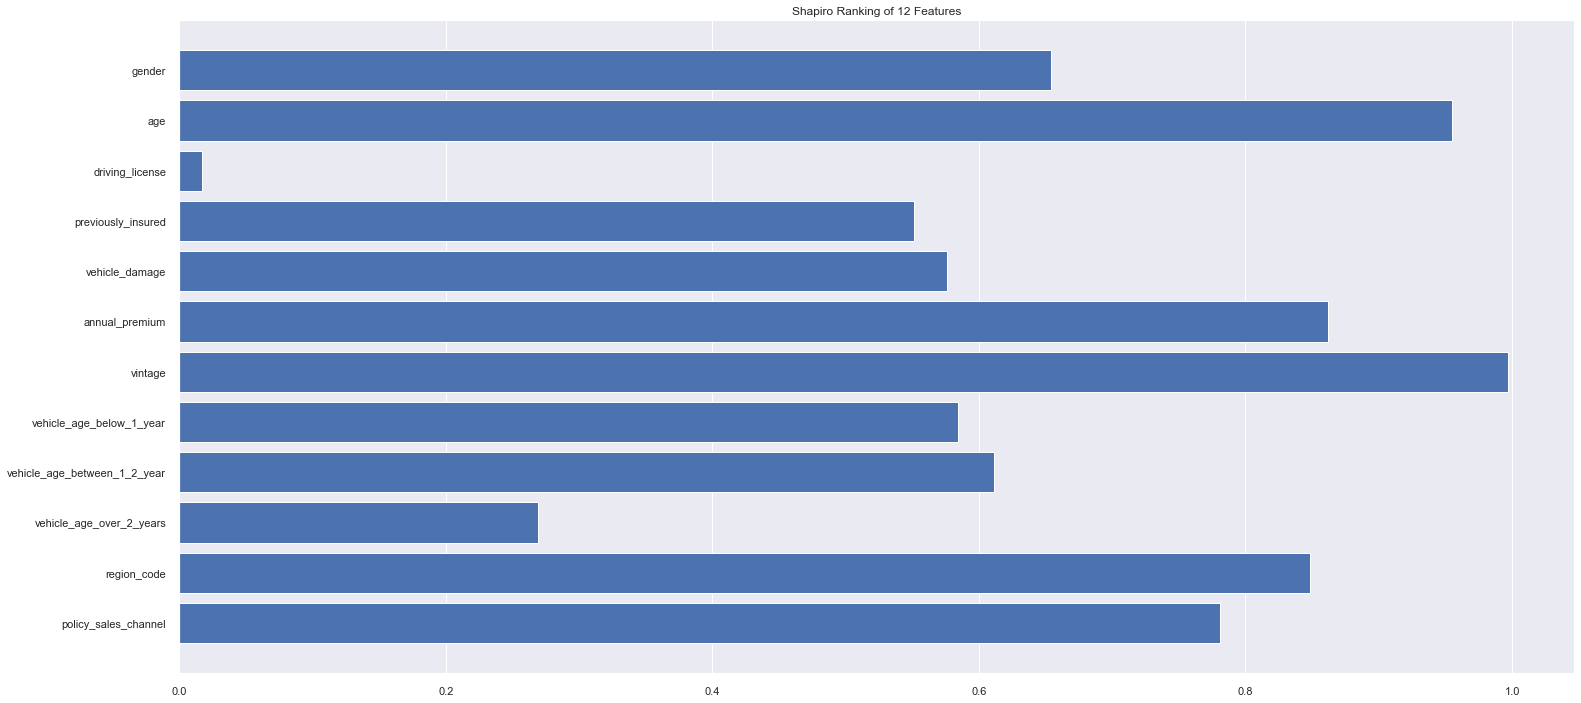

In [115]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x_train_res, y_train_res)           
visualizer.transform(x_train_res)        
visualizer.show(); 

## 6.2 Recursive Feature Elimination with Cross Validation

In [116]:
#preparing for selection
x_train_res_s = x_train_res.values
y_train_res_s = y_train_res.values.ravel()


Optimal number of features : 2


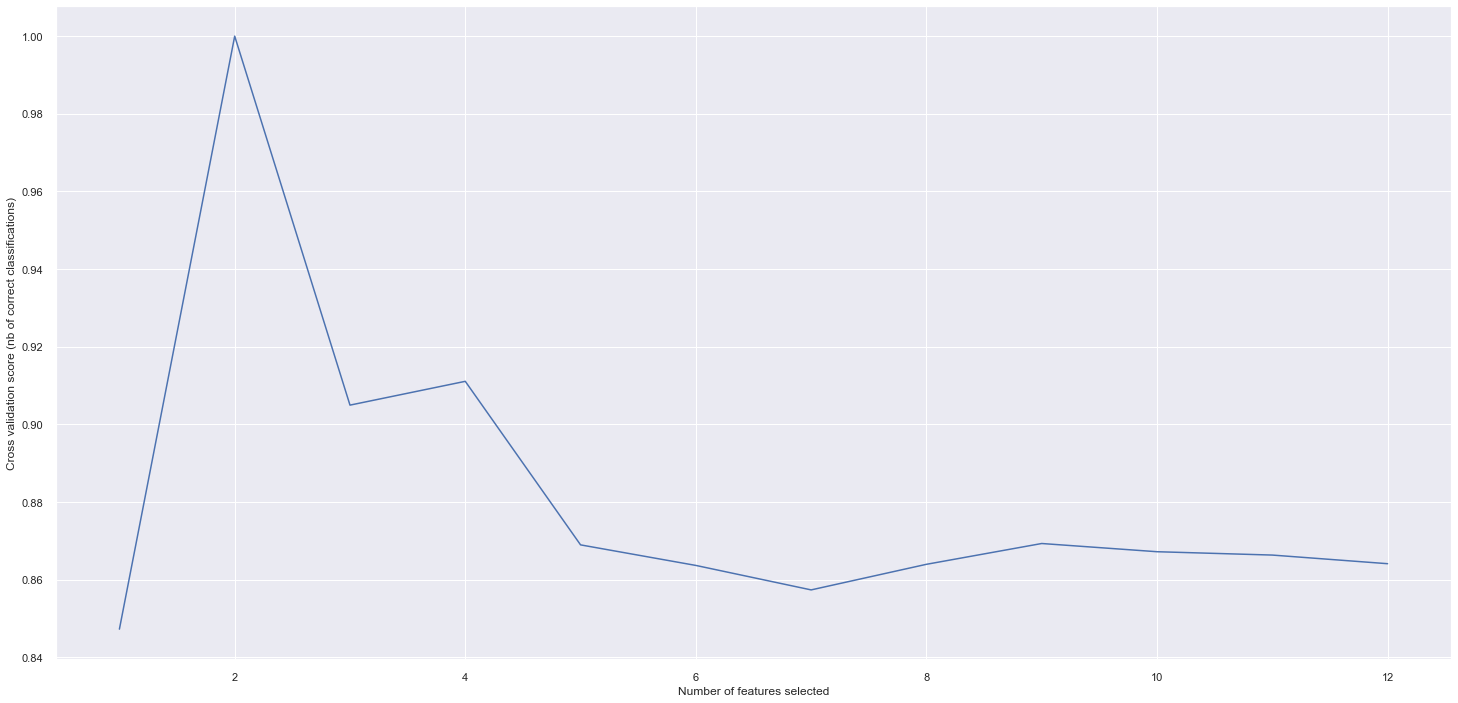

In [117]:
#Create the RFE object and compute a cross-validated score.
et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 )

min_features_to_select = 1  # Minimum number of features to consider

rfeet = RFECV(estimator = et, step = 1, cv = StratifiedKFold(2),
              scoring = 'precision',
              min_features_to_select= min_features_to_select)

rfeet.fit(x_train_res_s, y_train_res_s)

print("Optimal number of features : %d" % rfeet.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfeet.grid_scores_) + min_features_to_select),
         rfeet.grid_scores_)
plt.show()

In [118]:
print('--- RFECV Selected Columns ---')
print(' ')

for i in range(x_train.shape[1]):
    
    if rfeet.support_[i] == True:
        print(str(df4.columns[i]))
        print('Rank: %.2f' % rfeet.ranking_[i])
        print(' ')
    else:
        pass

--- RFECV Selected Columns ---
 
vehicle_damage
Rank: 1.00
 
vintage
Rank: 1.00
 


## 6.3 Boruta Algorithm

In [119]:
# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )
rf = RandomForestClassifier( n_jobs = -1 )

# Define boruta
boruta = bt.BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_res_s, y_train_res_s  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	5


In [120]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train.columns, cols_selected_boruta ) )

In [121]:
cols_selected_boruta

['age',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'vintage',
 'region_code',
 'policy_sales_channel']

In [122]:
cols_not_selected_boruta

['driving_license',
 'gender',
 'vehicle_age_below_1_year',
 'vehicle_age_between_1_2_year',
 'vehicle_age_over_2_years']

## 6.4 Feature Importance

In [123]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = x_train
y_train_n = y_train.values.ravel()
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.259800
0                annual_premium    0.236415
0                           age    0.157715
0                   region_code    0.101502
0          policy_sales_channel    0.094000
0                vehicle_damage    0.073135
0            previously_insured    0.049178
0      vehicle_age_below_1_year    0.013201
0  vehicle_age_between_1_2_year    0.006194
0                        gender    0.005404
0      vehicle_age_over_2_years    0.002967
0               driving_license    0.000489


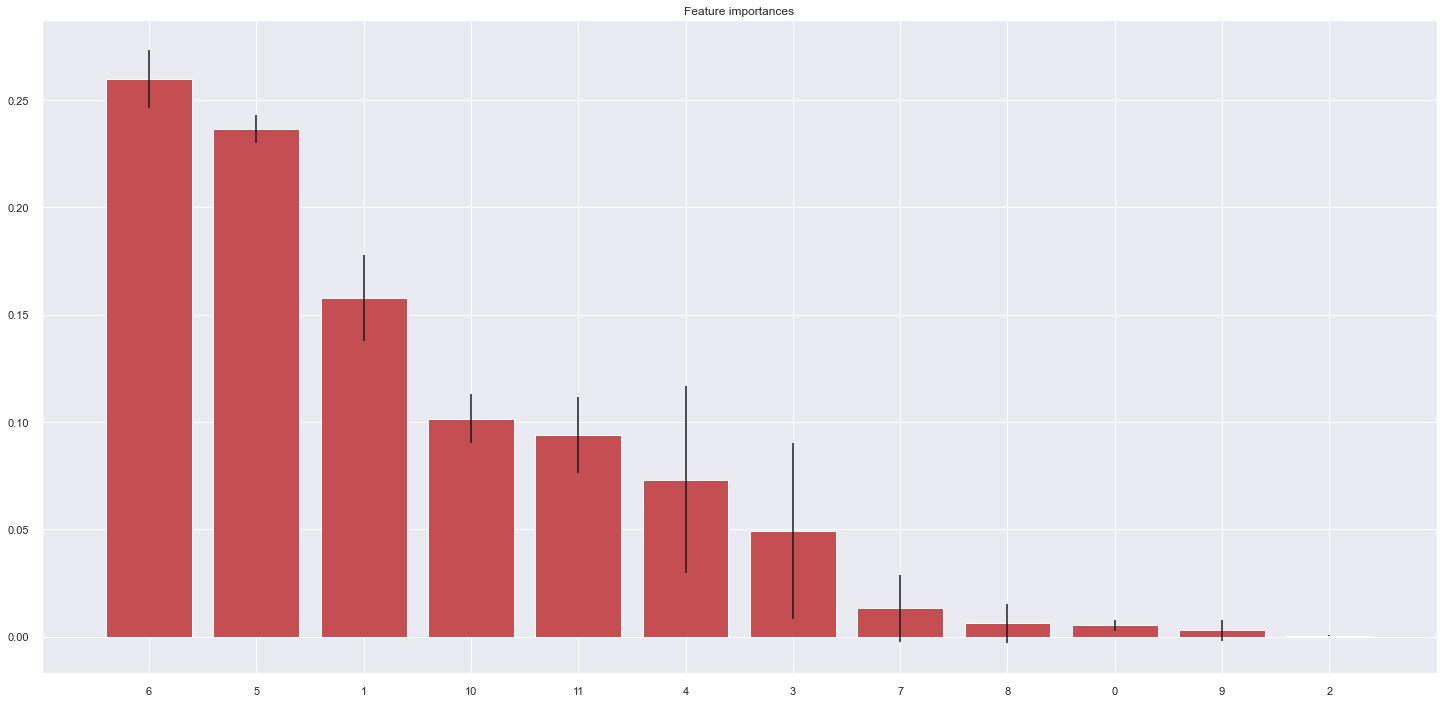

In [124]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()



# 7.0. Machine Learning Modelling

In [33]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']


In [34]:
x_train_res = x_train_res[cols_selected]
x_validation = x_validation[cols_selected]

## 7.1. KNN Classifier

In [127]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train_res,y_train_res.values.ravel())
    yhat = knn_model.predict(x_validation)
    mean_rcc[n-1] = balanced_accuracy_score(y_validation, yhat)

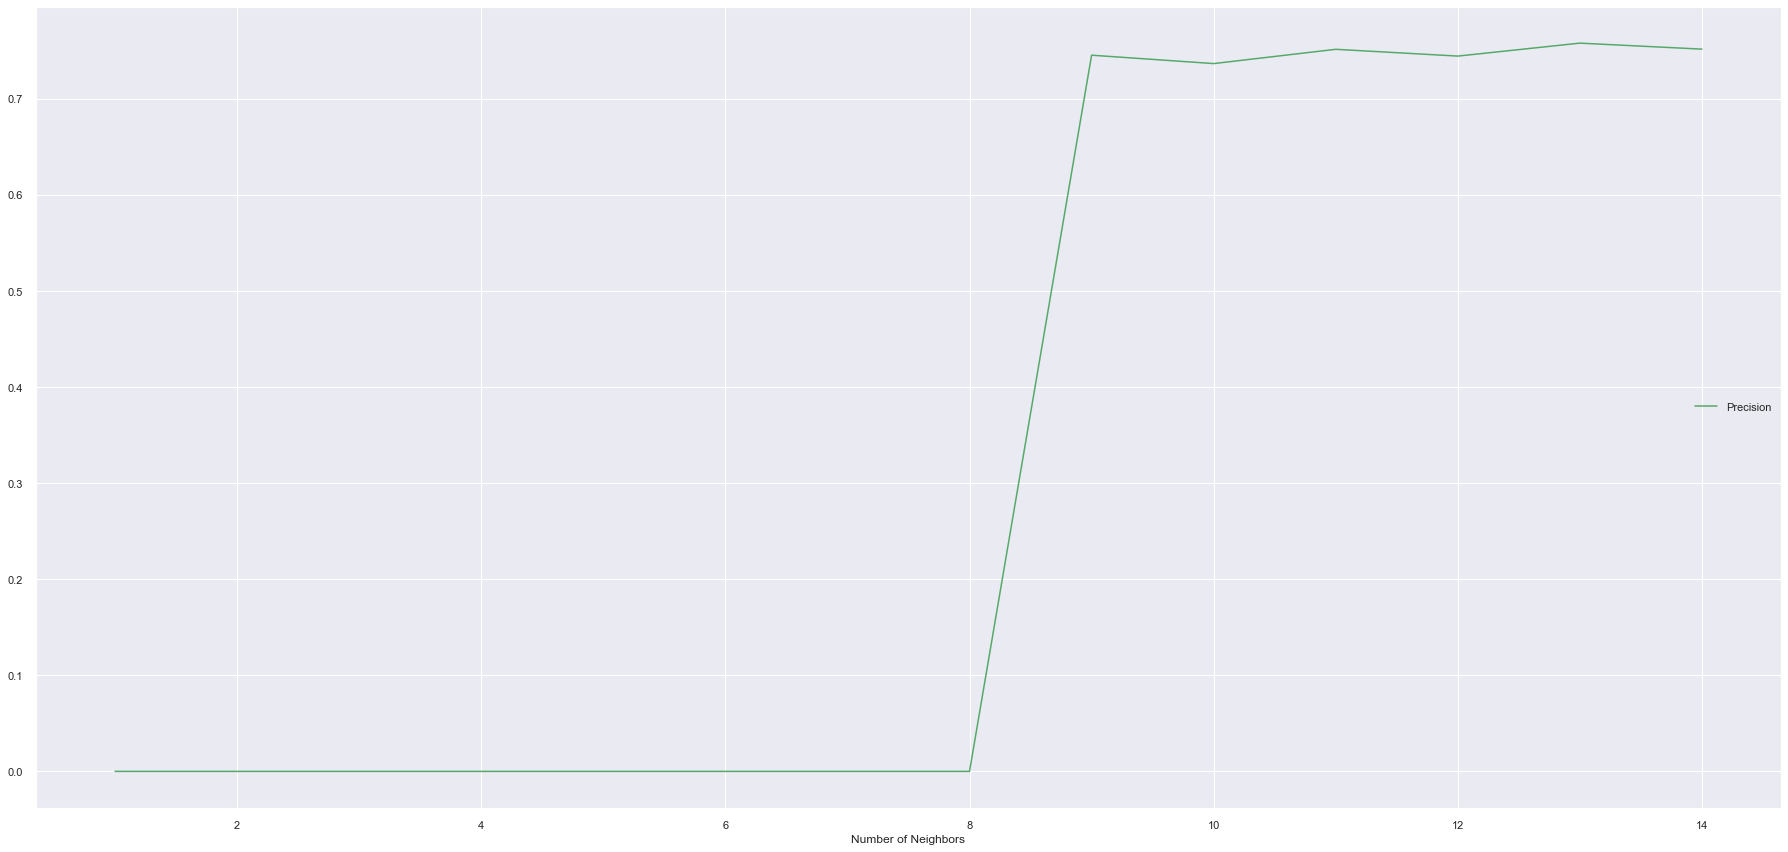

In [128]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [130]:
# model definition with k = 10
model_knn = nh.KNeighborsClassifier( n_neighbors = 10 )

# model training
model_knn.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_knn = model_knn.predict( x_validation ) 

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_knn)))

Balanced Accuracy: 0.736742557351231


## 7.2. Logistic Regression

In [131]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 ) 

# model training
lr_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_lr = lr_model.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_lr)))

Balanced Accuracy: 0.7915783505053544


## 7.3. Naive Bayes



In [132]:
#model definition
model_nb = GaussianNB()

#train model
model_nb.fit( x_train_res, y_train_res.values.ravel() )

#prediction
yhat_nb = model_nb.predict( x_validation )
yhat_nb_1 = model_nb.predict_proba( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_nb)))

Balanced Accuracy: 0.7856848469938482


## 7.4. Random Forest

In [133]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 0)

#train model
model_rf.fit( x_train_res, y_train_res.values.ravel() )

#predict
yhat_rf = model_rf.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_rf)))

Balanced Accuracy: 0.793394231740369


## 7.5 LGBM

In [134]:
model_lgbm=LGBMClassifier()
#model training
model_lgbm.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_lgbm = model_lgbm.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_lgb)))

Balanced Accuracy: 0.6970348313188282


## 7.6 XGBoost

In [135]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 2, 
                              subsample = 0.7,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9)

#model training
model_xgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_xgb)))

Balanced Accuracy: 0.7623602007792634


## 7.7 Real Model Perfomance: Cross Validation with Learning to Rank metrics

In [136]:
df5=df4.copy()

In [137]:
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, 5, df5, Verbose = False)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, 5, df5, Verbose = False)
lgb_val = cross_validation(model_lgb, x_train_res, y_train_res, 5, df5, Verbose = False)
nb_val = cross_validation(model_nb, x_train_res, y_train_res, 5, df5, Verbose = False)
rf_val = cross_validation(model_rf, x_train_res, y_train_res, 5, df5, Verbose = False)
knn_val= cross_validation(model_knn, x_train_res, y_train_res, 5, df5, Verbose = False)

In [139]:
results = pd.concat([xgb_val,lr_val,lgb_val,nb_val,rf_val,knn_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,GaussianNB,0.7899,0.7112,0.0013,0.9761,0.0007,0.7874,0.0022,0.3751,0.0011
0,KNeighborsClassifier,0.8460,0.7900,0.0017,0.9425,0.0015,0.8959,0.0052,0.4268,0.0025
0,LogisticRegression,0.7959,0.7332,0.0010,0.9305,0.0013,0.7954,0.0012,0.3789,0.0006
0,RandomForestClassifier,0.8005,0.7418,0.0019,0.9219,0.0041,0.8354,0.0009,0.3980,0.0004
0,LGBMClassifier,0.8876,0.8704,0.0023,0.9107,0.0018,0.9995,0.0001,0.4762,0.0000
0,XGBClassifier,0.7798,0.7524,0.0021,0.8340,0.0009,0.8236,0.0315,0.3924,0.0150


# 8.0 Hyperparameter Fine Tuning

In [108]:
def tune_lgbm(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_samples = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
              
    #Model
    model = LGBMClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_samples=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5],
                                    random_state=0, n_jobs=-1)

    model.fit(x_train_res, y_train_res)

    # Prediction
    yhat = model.predict(x_validation)

    # Prediction Proba
    yhat_proba = model.predict_proba(x_validation)[:,1]
    # Performance
    # model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc = m.roc_auc_score(y_validation, yhat_proba)
    
    return -roc

param = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_samples
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500)] #n_estimetors



result = forest_minimize(tune_lgbm, param, random_state=42, n_random_starts=15, n_calls=15, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.006259548184287541, 1, 1, 0.4008609501227462, 0.7984250789732436, 221]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.9133
Function value obtained: -0.8240
Current minimum: -0.8240
Iteration No: 2 started. Evaluating function at random point.
[0.0014321698289111518, 1, 1, 0.4397792655987209, 0.8005575058716045, 251]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.3990
Function value obtained: -0.7891
Current minimum: -0.8240
Iteration No: 3 started. Evaluating function at random point.
[0.004475983459259065, 1, 2, 0.37489944752007115, 0.9692763545078752, 485]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 21.4006
Function value obtained: -0.8291
Current minimum: -0.8291
Iteration No: 4 started. Evaluating function at random point.
[0.0015199348301309814, 1, 1, 0.186909009331792, 0.762378215816119, 335]
Iteration No: 4 ended. Evaluation done at random poin

In [109]:
result_list_lgbm = result.x
result_list_lgbm

[0.002324672848950434, 2, 2, 0.4033291826268562, 0.5998368910791799, 154]

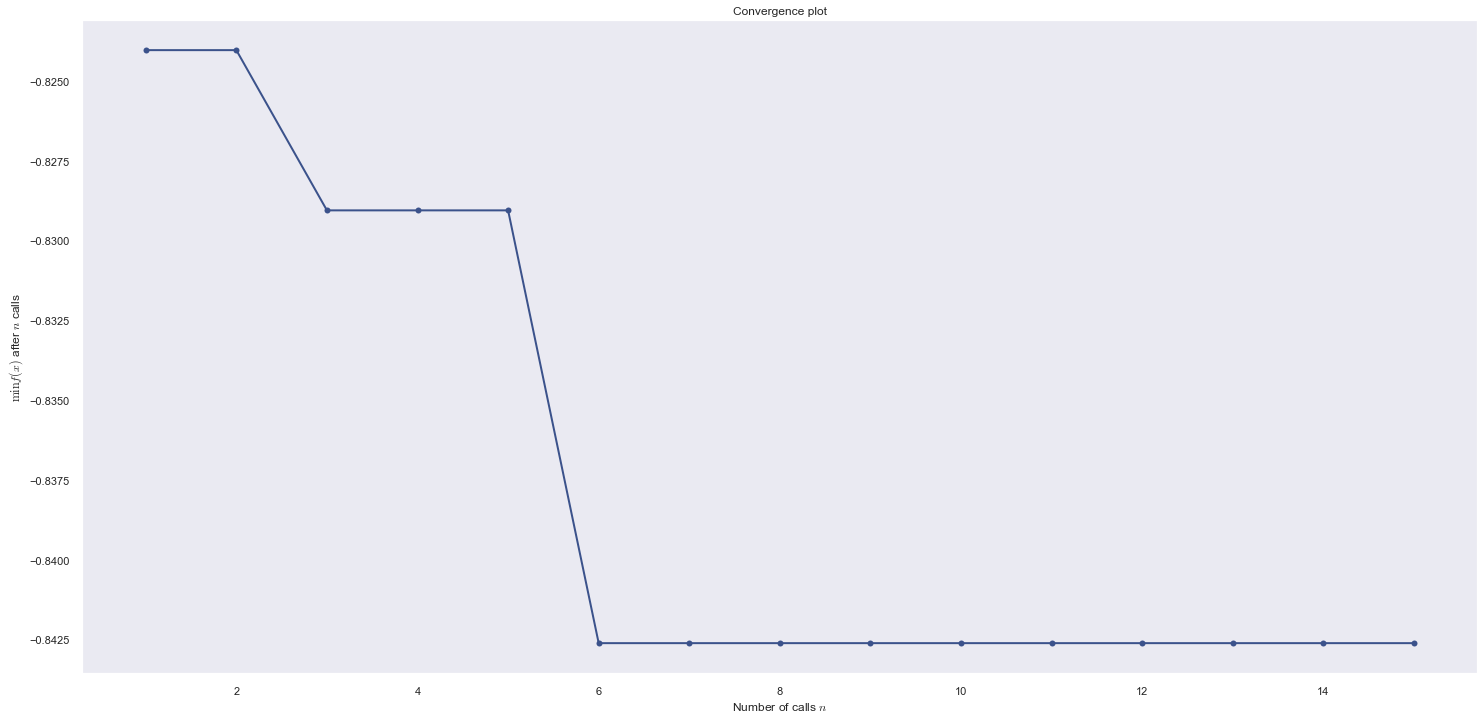

In [112]:
plot_convergence(result);

In [113]:
def tune_xgb(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]
    reg_lambda        = params[7]
    reg_alpha         = params[8]
    

    #Model
    model = xgb.XGBClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_weight=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5], gamma=params[6], reg_lambda=params[7],reg_alpha=params[8],
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

    model.fit(x_train_res, y_train_res)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(x_validation)

    # Prediction Proba
    yhat_proba = model.predict_proba(x_validation)[:,1]
    # Performance
#     model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    roc = m.roc_auc_score(y_validation, yhat_proba)
    
    return -roc



param = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_weight
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500), #n_estimetors
        (1.0, 6.0), #gamma
        (0, 9), #reg_lambda
        (40, 150)]#reg_alpha




result = forest_minimize(tune_xgb, param, random_state=42, n_random_starts=15, n_calls=15, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[0.006259548184287541, 1, 1, 0.4008609501227462, 0.7984250789732436, 221, 1.7799726016810133, 7, 139]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.4340
Function value obtained: -0.8258
Current minimum: -0.8258
Iteration No: 2 started. Evaluating function at random point.
[0.001389526449426104, 1, 2, 0.07538521056219512, 0.8609993861334124, 393, 1.0038938292050716, 4, 72]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.0035
Function value obtained: -0.7891
Current minimum: -0.8258
Iteration No: 3 started. Evaluating function at random point.
[0.0020148477884158653, 2, 1, 0.24437525838895213, 0.645614570099021, 158, 2.999304858576278, 2, 147]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.6999
Function value obtained: -0.8412
Current minimum: -0.8412
Iteration No: 4 started. Evaluating function at random point.
[0.003267641765781762, 2, 1, 0.0709026857239989

In [114]:
result_list_xgb = result.x
result_list_xgb

[0.008753903518006048,
 2,
 2,
 0.2234374261429623,
 0.5079831261101071,
 485,
 4.421165132560786,
 6,
 83]

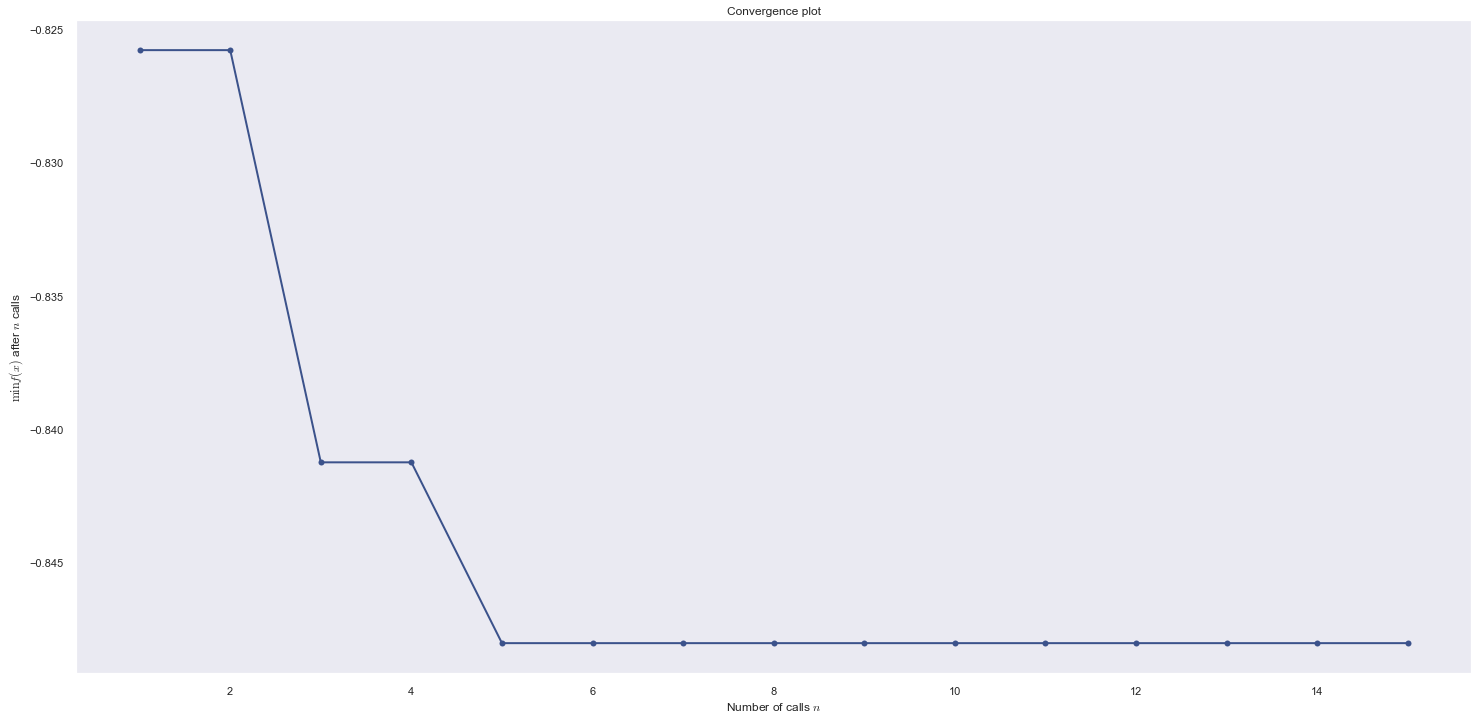

In [115]:
plot_convergence(result);

# 9.0 Final Model

In [35]:
df5=df4.copy()

In [36]:
model_lgbm = LGBMClassifier()

#training
lgbm_val = cross_validation(model_lgbm, x_train_res, y_train_res, 10, df5, Verbose = True)

# prediction
yhat_lgbm = model_lgbm.predict_proba( x_validation )

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


# 10.0 Business Perfomance

In [45]:
data = x_validation.copy()

data['response'] = y_validation.copy()
#data['score'] = yhat_nb[:, 1].tolist()
data['score'] = yhat_lgbm[:, 1].tolist()
data = data.sort_values('score', ascending=False)

## 10.1 --- 20.000 Calls ---

In [82]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)
precision_at_20000=precision_at_k(data,k=20000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 20000: ',recall_at_20000)
print('Precision at 20000: ',precision_at_20000)

Percent of Data:  0.3282778543759438
Recall at 20000:  0.8096256684491978
Precision at 20000:  0.30278486075696215


 By using 32,82% of validation data, in which would translate as 20 thousand calls by the sales team, the model would be able to identify 80.96% people out of the total people interested in purchasing the insurance.

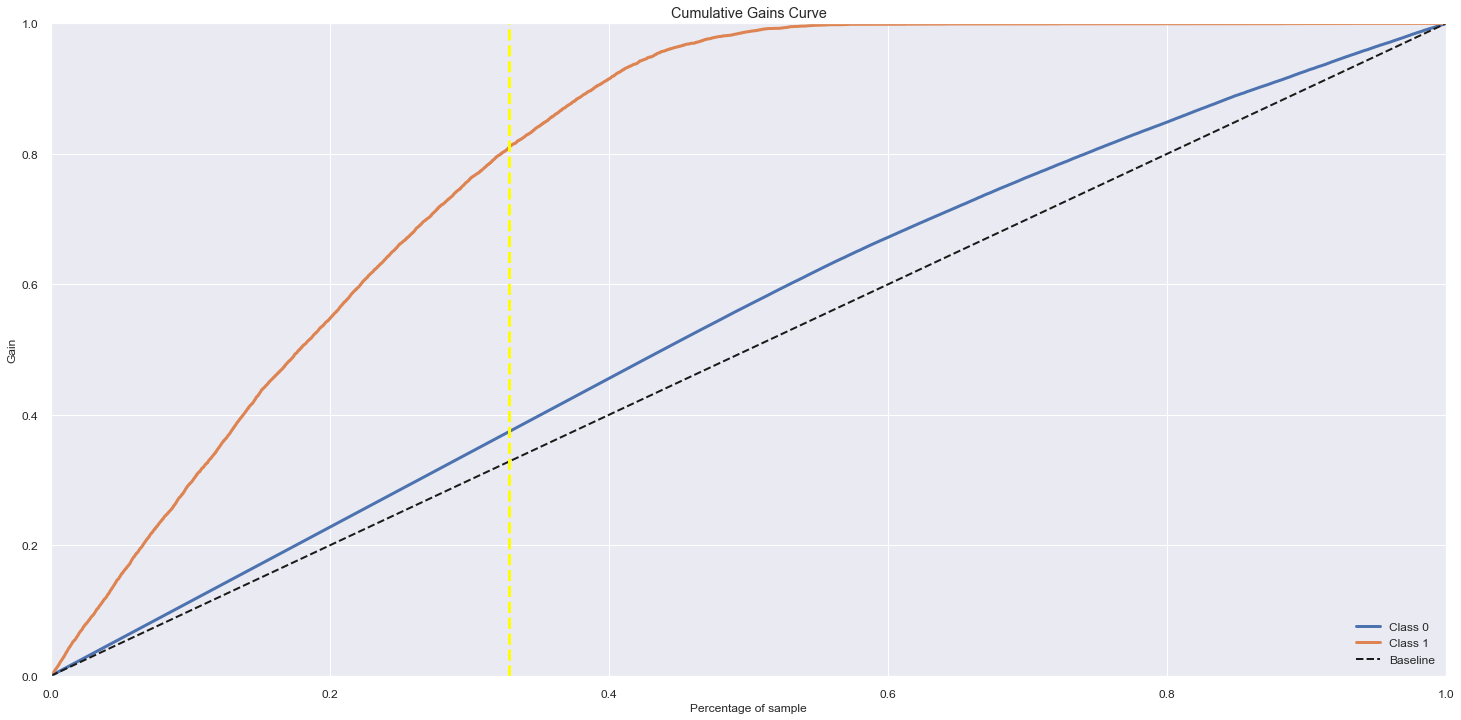

In [84]:
#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

By Making 20 thousand calls, the model proposed is roughly 2,5 times better than random choice.

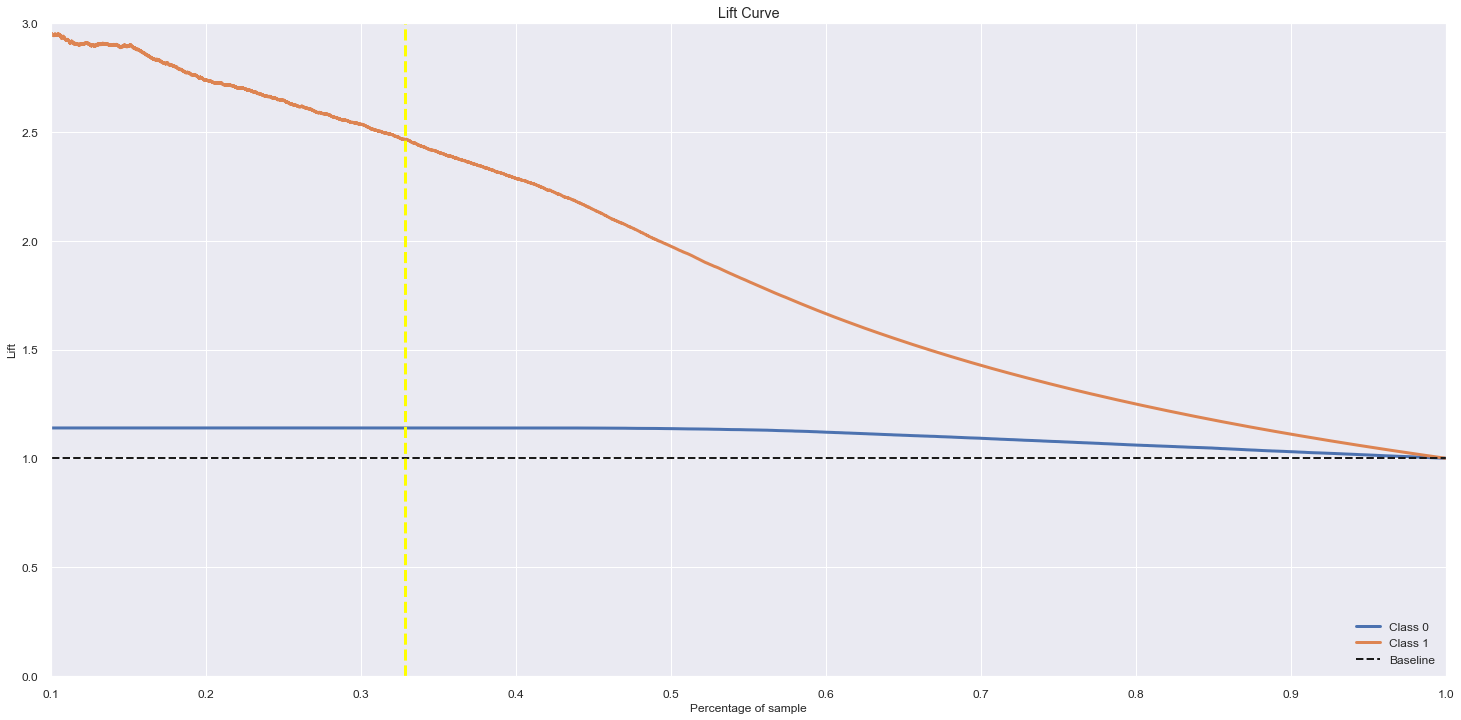

In [85]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

## 10.2 --- 40.000 Calls ---

In [86]:
percent_of_dataset = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k = 40000)
precision_at_40000=precision_at_k(data,k=40000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 40000: ',recall_at_40000)
print('Precision at 40000: ',precision_at_40000)


Percent of Data:  0.6565557087518876
Recall at 40000:  0.9991978609625668
Precision at 40000:  0.18684532886677832


By using 65.65% of validation data, in which wold translate as 40 thousand calls by the sales team, the model would be able to identify 99.91% people out of the total people interested in purchasing the insurance.

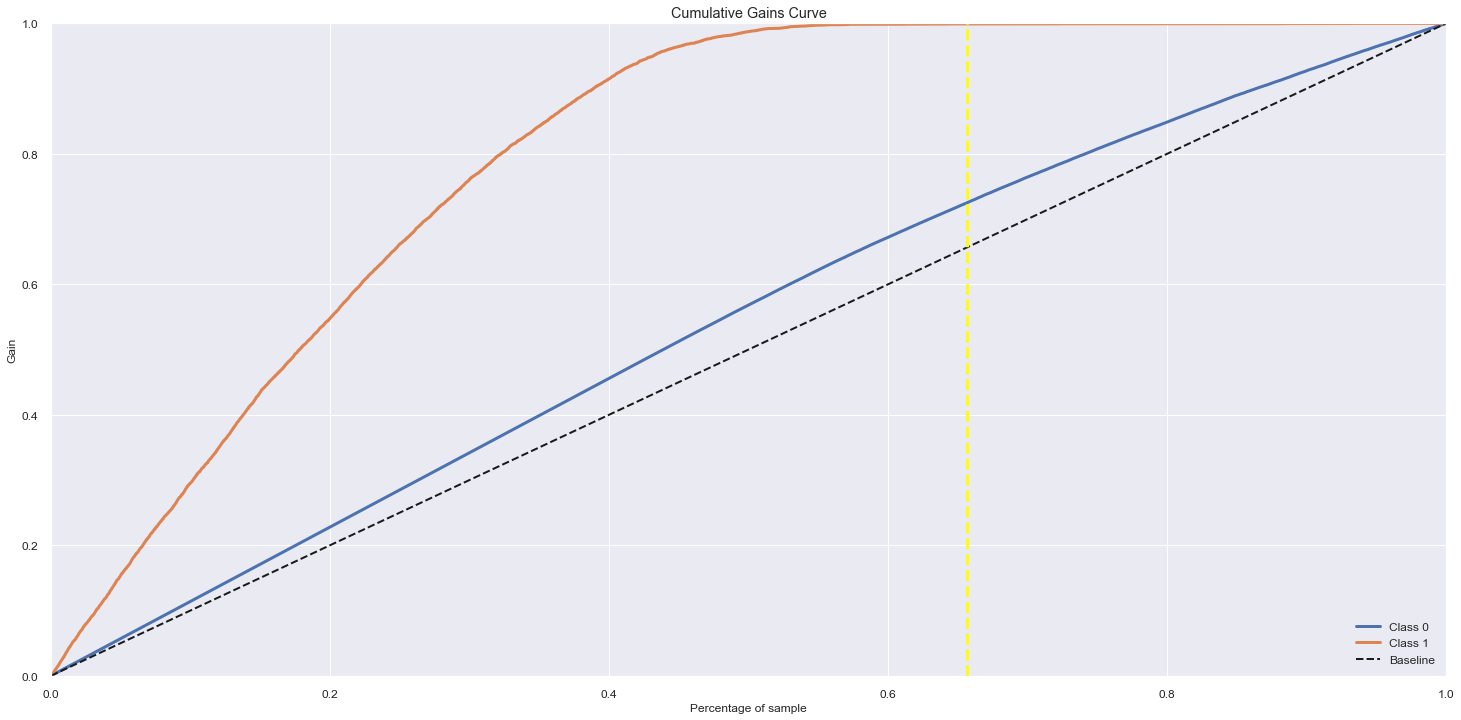

In [87]:
# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

 By Making 40 thousand calls, the model proposed is roughly 1,6 times better than random choice.

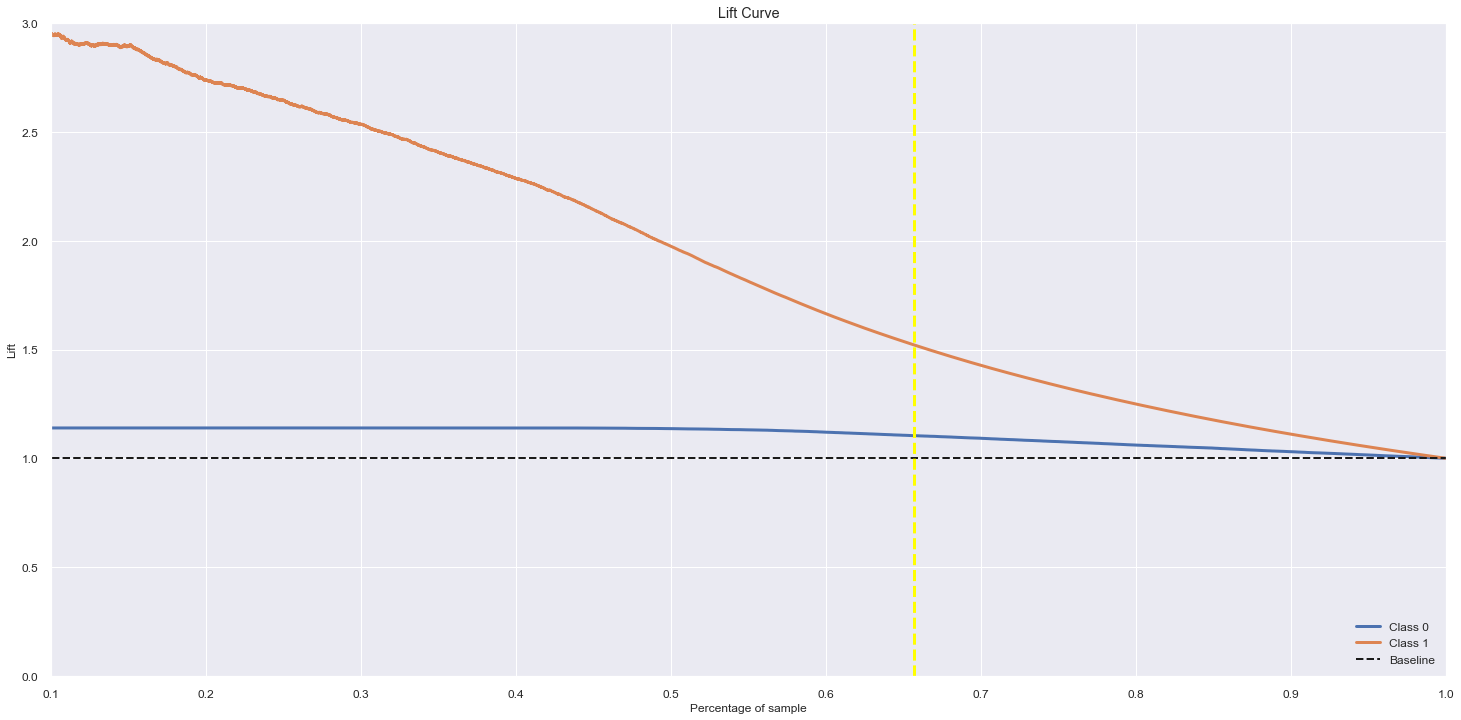

In [89]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

## 10.3 Business Perfomence on 127.000 New Customers

### 10.3.1 Revenue by making 20.000 Calls

In [63]:
random_choice = (33/100) * 127000
model         = (81/100) * 127000

x = random_choice * (2000*12)
y = model * (2000*12)
dif=y-x

print('{} Annual revenue with random choice'.format(x))
print('{} Annual revenue with model'.format(y))
print('difference in $: {} '.format(dif)  )

1005840000.0 Annual revenue with random choice
2468880000.0 Annual revenue with model
difference in $: 1463040000.0 


### 10.3.2 Revenue by making 40.000 Calls

In [64]:
random_choice = (65/100) * 127000
model         = (99/100) * 127000

x = random_choice * (2000*12)
y = model * (2000*12)
dif=y-x

print('{} Annual revenue with random choice'.format(x))
print('{} Annual revenue with model'.format(y))
print('difference in $: {} '.format(dif)  )

1981200000.0 Annual revenue with random choice
3017520000.0 Annual revenue with model
difference in $: 1036320000.0 


### 10.3.3  How many calls to reach 80% of peaple interested

Entre com o valor de ligações que deseja realizar: 19500
Percent of Data:  0.3200709080165452
Recall at 19500:  0.796524064171123
Precision at 19500:  0.30552279370288704


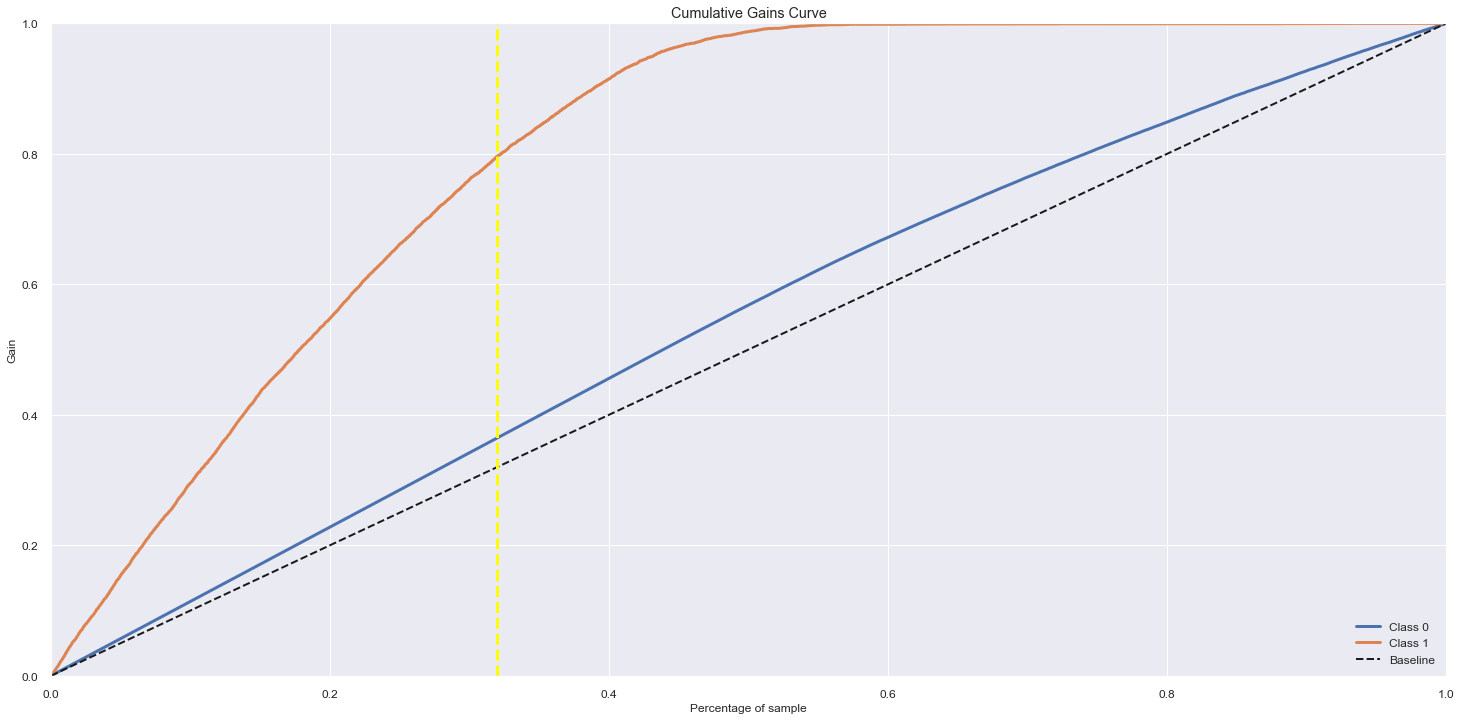

In [81]:
num=input('Entre com o valor de ligações que deseja realizar: ')
percent_of_dataset = int(num) / len(data)
recall_at_num = recall_at_k(data, k = int(num))
precision_at_num=precision_at_k(data,k=int(num))

print('Percent of Data: ',percent_of_dataset)
print('Recall at {}: '.format(num),recall_at_num)
print('Precision at {}: '.format(num),precision_at_num)

skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

# 11.0 Model Generalization Test


In [97]:
df_test= future_test.copy()

In [98]:
#df_test.drop(columns = ['response'], inplace = True)

In [99]:
df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
18,186,Male,52,1,0.0,1,1-2 Year,No,2630.0,26.0,134,0
21,221,Female,44,1,28.0,1,1-2 Year,No,2630.0,124.0,114,0
22,244,Male,49,1,28.0,0,1-2 Year,Yes,45558.0,26.0,49,0
36,323,Female,22,1,28.0,0,< 1 Year,Yes,48276.0,152.0,290,0


In [100]:

# Vehicle Damage Number
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df_test['vehicle_age'] =  df_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

annual_premium_scaler       =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/annual_premium_scaler.pkl','rb' ) )
age_scaler                  =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/age_scaler.pkl','rb' ) ) 
target_encode_vintage_scaler              =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_vintage_scaler.pkl','rb' ) ) 
target_encode_gender_scaler =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_gender_scaler.pkl','rb' ) )
target_encode_region_scaler =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_region_scaler.pkl','rb' ) )
target_encode_policy_sales_channel_scaler =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_policy_sales_channel_scaler.pkl','rb' ) )


# anual premium - StandarScaler
df_test['annual_premium'] = annual_premium_scaler.transform( df_test[['annual_premium']].values )


# Age - MinMaxScaler
df_test['age'] = age_scaler.transform( df_test[['age']].values )

# Vintage - Target Encoding
df_test.loc[:, 'vintage'] = df_test['vintage'].map( target_encode_vintage_scaler )

# gender - One Hot Encoding / Target Encoding
df_test.loc[:, 'gender'] = df_test['gender'].map( target_encode_gender_scaler )

# region_code - Target Encoding
df_test.loc[:, 'region_code'] = df_test['region_code'].map( target_encode_region_scaler )


# vehicle_age - One Hot Encoding / Frequency Encoding
df_test = pd.get_dummies( df_test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map( target_encode_policy_sales_channel_scaler )




df_test.drop(columns = ['id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year',
                 'vehicle_age_over_2_years',
                 'region_code',
                 'policy_sales_channel',
                'response']
            
#keeping response as the last column for better slicing
df_test = df_test.reindex(columns = columns_order)

y_df_test = df_test.iloc[:, -1:]


cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_df_test = df_test[cols_selected]


In [101]:
# model_lgbm=pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_health_insurance.pkl', 'rb' ) )
pred = model_lgbm.predict_proba( x_df_test )
    

## 11.1 --- 20.000 Calls ---

Percent of Data:  0.2635497516043591
Recall at 20000:  0.6868782071421091
Precision at 20000:  0.327933603319834


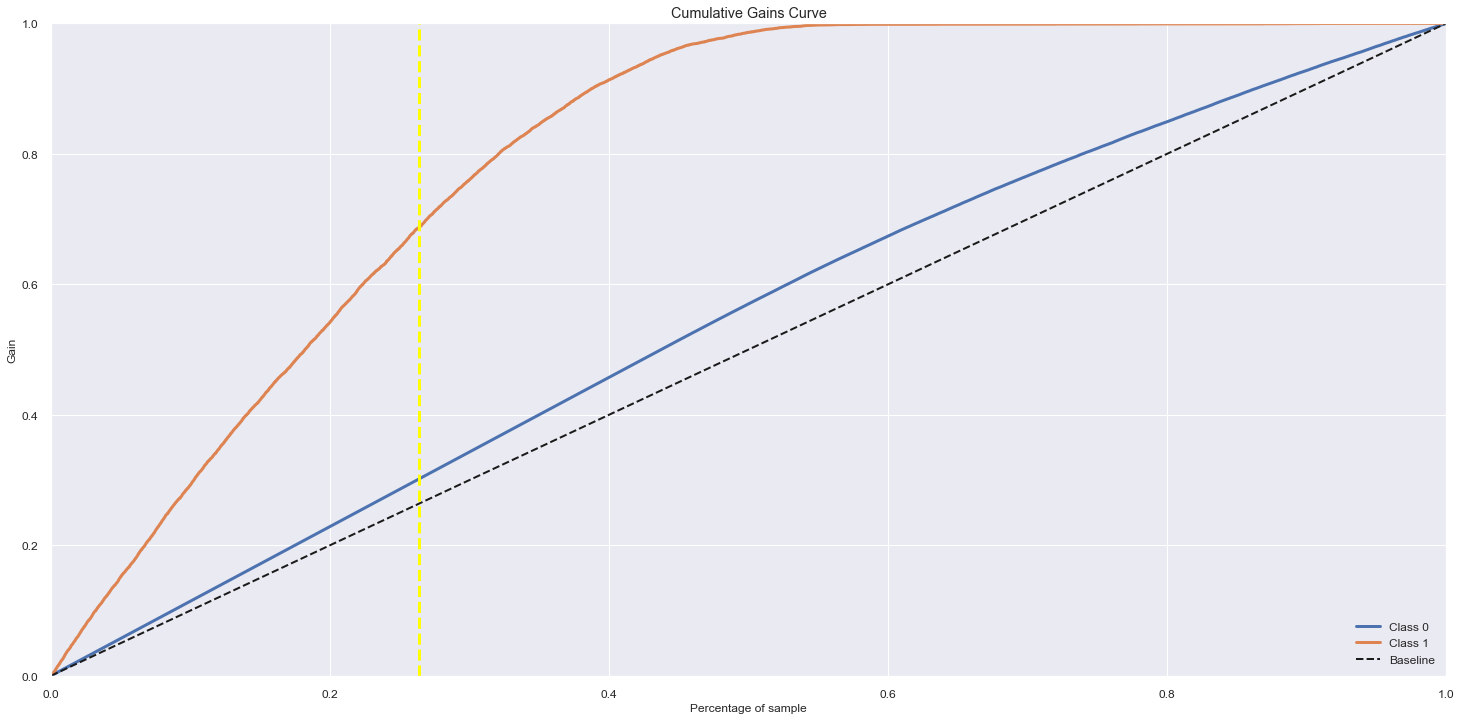

In [102]:
data = x_df_test.copy()

data['response'] = y_df_test.copy()
data['score'] = pred[:, 1].tolist()
data = data.sort_values('score', ascending=False)

percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)
precision_at_20000=precision_at_k(data,k=20000)
print('Percent of Data: ',percent_of_dataset)
print('Recall at 20000: ',recall_at_20000)
print('Precision at 20000: ',precision_at_20000)

#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

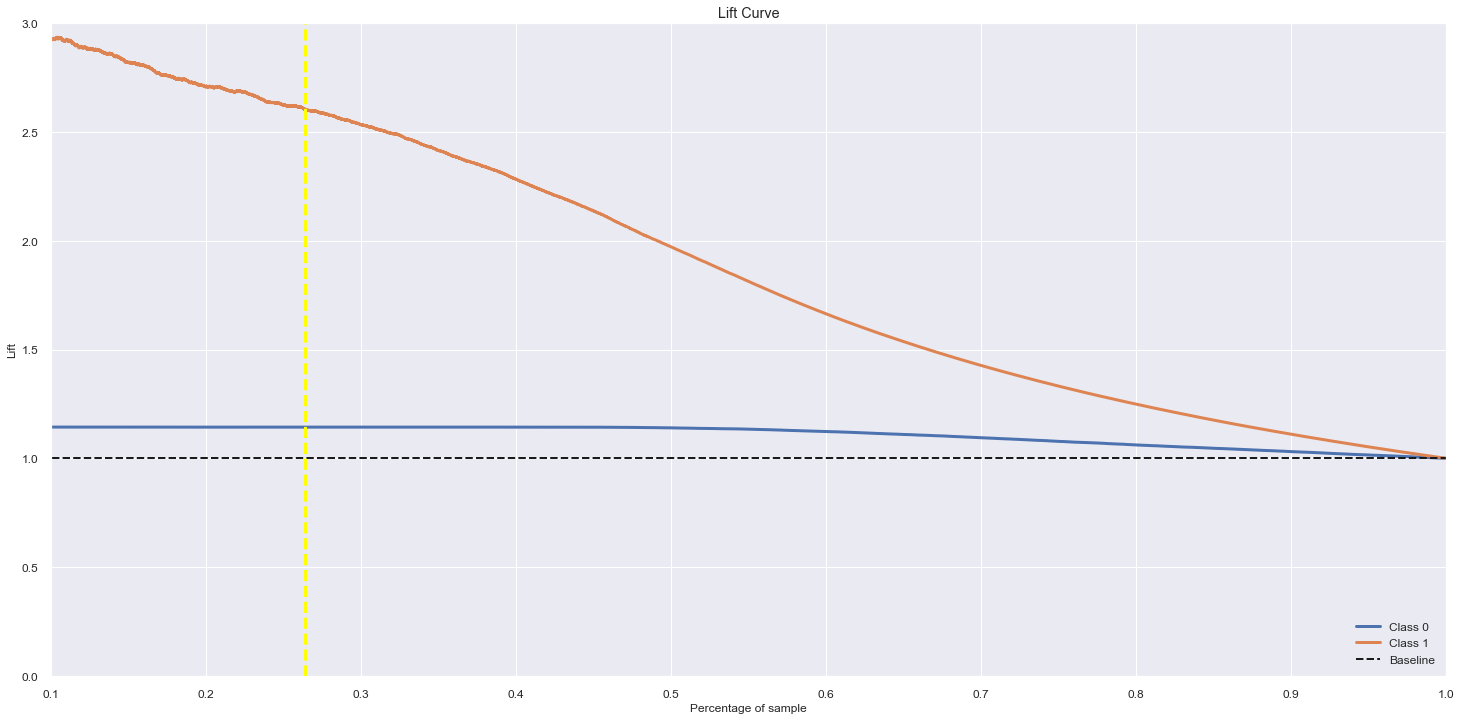

In [103]:
skplt.metrics.plot_lift_curve(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

## 11.2 --- 40.000 Calls ---

Percent of Data:  0.5270995032087182
Recall at 40000:  0.9941355115718924
Precision at 40000:  0.23731906702332442


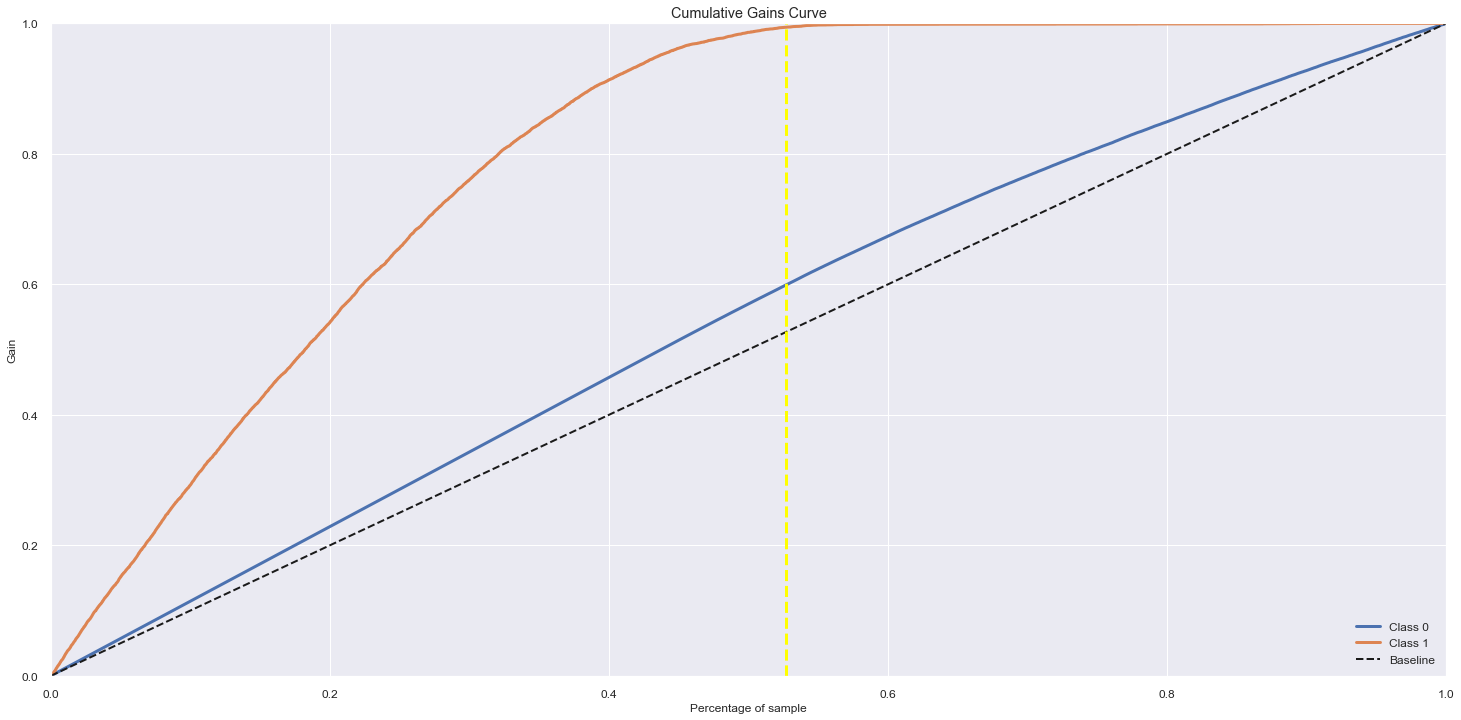

In [104]:
percent_of_dataset = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k = 40000)
precision_at_40000=precision_at_k(data,k=40000)

print('Percent of Data: ',percent_of_dataset)
print('Recall at 40000: ',recall_at_40000)
print('Precision at 40000: ',precision_at_40000)

# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

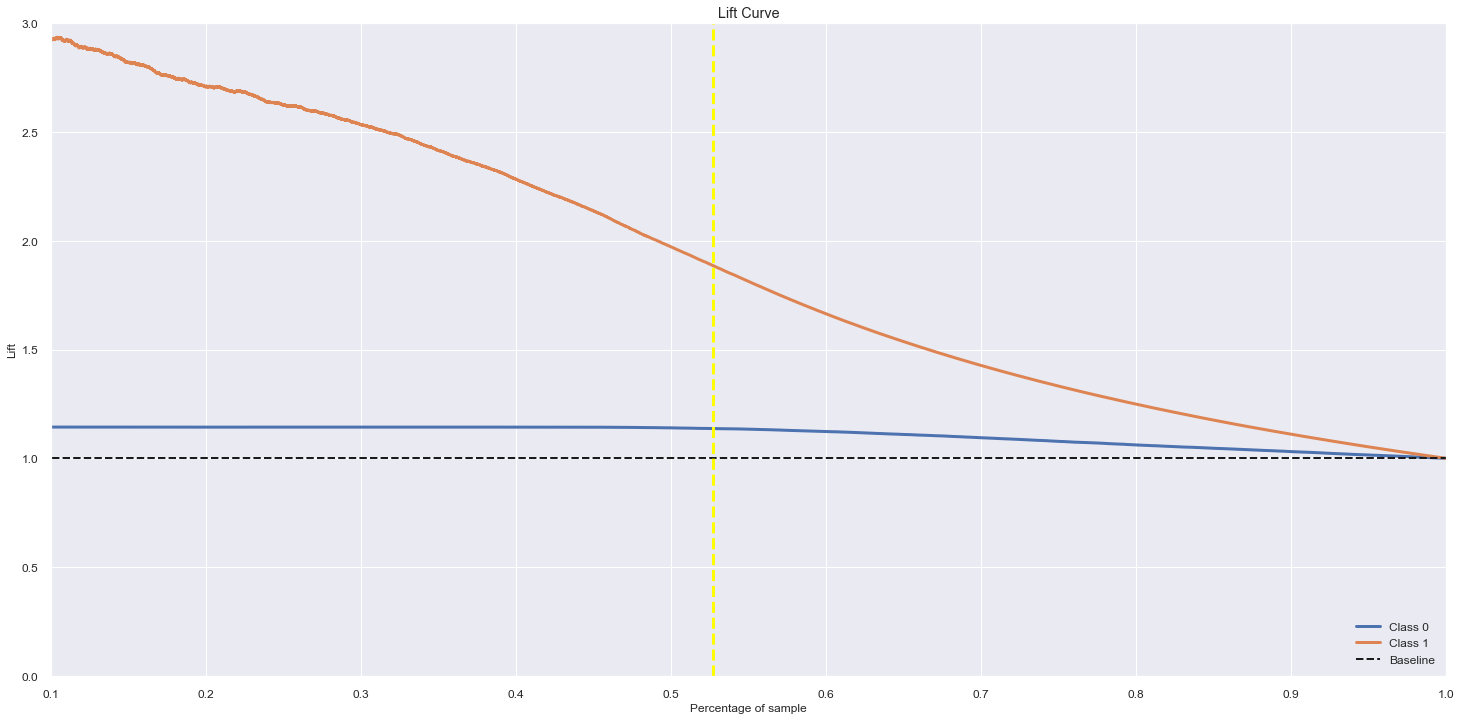

In [105]:
skplt.metrics.plot_lift_curve(y_df_test, pred)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);


# 12.0. Deploy to Production

In [51]:
# Save trained model
pickle.dump( model_lgbm, open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_health_insurance.pkl','wb'  ) )
# pickle.dump( lr_model, open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_linear_regression.pkl', 'wb' ) )

## 12.1 Health Insurance Class

In [17]:
import pickle
import numpy  as np
import pandas as pd


class HealthInsurance( object ):
    def __init__( self ):
        self.home_path = ''
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'features/age_scaler.pkl', 'rb' ) ) 
        self.target_encode_vintage_scaler =                   pickle.load( open( self.home_path + 'features/target_encode_vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_scaler = pickle.load( open( self.home_path + 'features/target_encode_region_scaler.pkl', 'rb' ) )
        self.target_encode_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'features/target_encode_policy_sales_channel_scaler.pkl', 'rb' ) )
    
    
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df3 ):
        # anual premium - StandarScaler
        df3['annual_premium'] = self.annual_premium_scaler.transform( df3[['annual_premium']].values )

        # Age - MinMaxScaler
        df3['age'] = self.age_scaler.transform( df3[['age']].values )

        # Vintage - MinMaxScaler
        df3.loc[:, 'vintage'] = df3['vintage'].map( self.target_encode_vintage_scaler )

        # gender - One Hot Encoding / Target Encoding
        df3.loc[:, 'gender'] = df3['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding with Kfold
        df3.loc[:, 'region_code'] = df3['region_code'].map( self.target_encode_region_scaler )
         
        # vehicle_age - One Hot Encoding / Frequency Encoding
        df3 = pd.get_dummies( df3, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map( self.target_encode_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df3[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

## 12.2 API Handler

In [20]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
model = pickle.load( open( path + 'src/models/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

ModuleNotFoundError: No module named 'healthinsurance'

# 13.0 API Tester

In [77]:
import requests

In [78]:
# loading test dataset
df_test= future_test.copy()


In [79]:
df_test = df_test.sample(5)
df_test.drop(columns = ['response'], inplace = True)


In [80]:
df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
336321,21272,Male,76,1,28.0,1,1-2 Year,No,40318.0,25.0,166
53864,48681,Female,23,1,8.0,1,< 1 Year,No,33863.0,160.0,243
326684,324659,Female,61,1,28.0,0,1-2 Year,No,37655.0,26.0,245
307866,173723,Female,48,1,35.0,0,1-2 Year,Yes,28533.0,10.0,58
278194,317870,Male,24,1,11.0,1,< 1 Year,No,35511.0,152.0,133


In [81]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [82]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://lujanrr-healthinsurance.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [83]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head(50)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
3,173723,0.10349,0.430769,1,0.119540,0,between_1_2_year,1,-0.119222,10.0,0.126306,0.970974
2,324659,0.10349,0.630769,1,0.186594,0,between_1_2_year,0,0.411540,26.0,0.103575,0.488784
4,317870,0.13827,0.061538,1,0.110523,1,below_1_year,0,0.286792,152.0,0.134578,0.063318
1,48681,0.10349,0.046154,1,0.095974,1,below_1_year,0,0.190903,160.0,0.114953,0.003870
0,21272,0.13827,0.861538,1,0.186594,1,between_1_2_year,0,0.566486,25.0,0.112381,0.002512


LTR Point wise